# Data Cleaning and processing (Base dataset)

Actions to be implemented here :

1) Inspection of the data
2) Data Cleaning
3) Descriptive statistics & Visualization


## Data Import and Processing

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [89]:
from pathlib import Path
DATADIR= Path("/workspaces/fraud-detection-BAF-Dataset-Suite-/FraudDataset")
data_dir =DATADIR
if not data_dir.exists():
    raise FileNotFoundError(f"Data directory not found: {data_dir}")
extension = "csv"  # Change to "csv" if needed
data_paths = [str(p) for p in sorted(data_dir.glob(f"*.{extension}"))]
data_paths[0]
dataset=pd.read_csv(data_paths[0], index_col=0)


In [90]:
dataset.head(5)
dataset.reset_index(inplace=True)

As suggested also in the paper, to mimic real-production behaviors, where fraud customers change their own behavior with the passage of months to avoid being detected, we will assume the following split:

1) Train split: 6 first months
2) Test split: 2 latter months split

By this way, we adopt a common train-test splitting strategy used in fraud detection domain. By this way we may introduce distribution shift (since prevalence rate according to the paper may have changed due to higly dynamic environment), **however** it constitutes a more realistic and robust way to evaluate the models. In a real production environment, we always train on past data and predict on future data. A random split would lead to data leakage, as the model would "see" future fraud patterns during training that it wouldn't have access to in real life

In [91]:
dataset.month.unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [92]:
train_dataset=dataset.loc[dataset["month"]<6,:].copy()
test_dataset=dataset.loc[dataset["month"]>=6,:].copy()

Questions for columns: 

1) How come the intended_balcon_amount is <0? ===> **Answer**: <0 are missing values => user did not transfer any amount or not recorded from the system.
2) What does credit_risk_score reflect => **Answer** The higher, the riskier.
3) Why month has only 7 values? I would expect 12. **Answer** Probably, these would be months of new banking accounts creation marketing campaing.
4) keep_alive_session=1 reflects that the user did not made a logout? **Answer** Yes.

5) I think that a "distinct" separation is whether the user is already customer of the bank. For example, the prev_address_months_count should be >0 only for applicants who have registered also their own previous address => they have redistered another time in the past in bank. Also there may be cases that a customer has cards in the bank (has_binary_cards=yes) but no current account (bank_months_count<0~missing) who may be a customer with different product than an account (e.g. card). Such customer may be considered card holder but without enough financial stability. In general, we will consider the **interaction of has_other_cards, bank_months_count, prev_address_months_count and current_address_months_count** to create a customer profile with multiple levels.


### Inspect which of them need filling their own missing values

1. **prev_address_month_count**: -1 here may imply that there is not even a previous registered address of the applicant => so no need for them to impute here an approximation for them. **No need also** for deleting such cases. **No need here for imputing---> Give proper focus on such customers not having previous address valid duration (either staying for long time to the current address or no valid duration implying potential fraud or just wrong application).**.

2. **current_address_month_count**: Similarly, with above.

3. **intended_balcon_amount**: Since <0 implies that user did not transfer any amount at the beginning, this means that he has  not made initially any transfer  for the application. Then, such cases should not be imputed since they contain important info since the fact that they did not make intitial transfer may be a distinction between fraud and non-fraud. **No need here for imputing**.

4. **velocity_6h**? why negative number? here is not something provided by the user but from the system. so since the velocity is <0, we may need to impute here to have an approximation.  **Need here for imputing: How? ---> Good solution would be to find applications within last 6 hours and impute the mean of velocity_6h for then. However, 44 only observations were found to be missing and all of them are cases with days_since_request<=0.25, last 6 hours**.

5. **credit_risk_score**: Negative number here may indicate very low score. **No need here for imputing**.

6. **bank_months_count**: Here <0 implies that the previous account of user is not existent. So he is **either** new user  **or** a user without previous prdocut in the bank . **===> Answer** The cases where <0 denote missingness rather than a patterna nd such cases will be evaluated under potential interaction with other features such as has_other_cards, bank_months_count, prev_address_months_count and current_address_months_count.

7. **session_length_in_minutes**: Both teleapp and internet (Source feature) presented missingness. **=> Answer**. **Need here for imputing. First, log the covariate and then impute. Another transformation techniques could be tested but this one produces symmetrical distribution**.

8. **device_distinct_emails**: Probably here the 0 implies that during last 8 weeks there was not another e-mail (another from the original one) that appeared. So, the missing value implies tha the "monitoring" system of the bank did not recognize such info which means that during the last 8 weeks the user was not even apparent (thus, reasonable to have missing value) or the system did not work properly -> need to impute such cases.
Let's be sure about cases where the days_since_request was almost 0 which means that  in such cases the system may not have had the necessary time to detect such info. From below, it seems that there are missing cases where the days of request were >0 which implies that such missing cases are not solely cases of very "freshly" registered people. Thus, probably, there was system dis-functionality ===>**ANSWER: Need for imputing or to separate them as category**.



#### **Income**

In [93]:
train_dataset["income"].value_counts()

income
0.9    162202
0.1    134849
0.8    112291
0.6     89948
0.7     82920
0.4     66802
0.2     58068
0.5     45604
0.3     42305
Name: count, dtype: int64

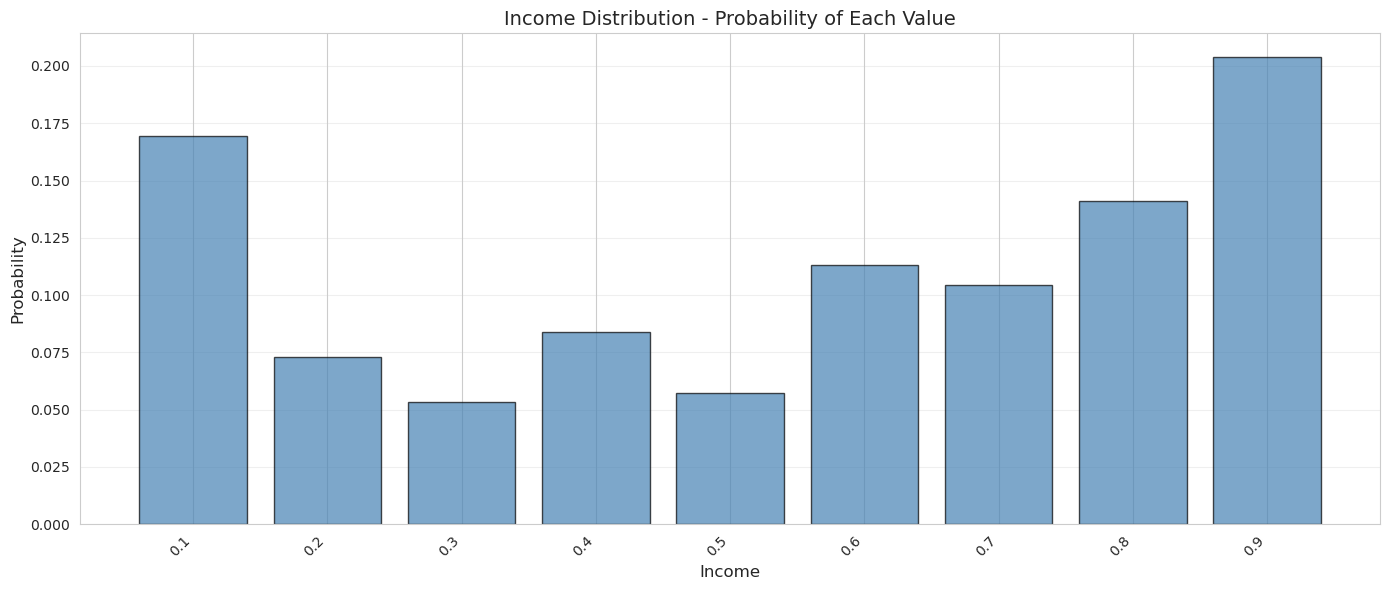

Income Probabilities:
income
0.1    0.169624
0.2    0.073043
0.3    0.053215
0.4    0.084029
0.5    0.057364
0.6    0.113144
0.7    0.104303
0.8    0.141248
0.9    0.204030
Name: count, dtype: float64


In [94]:
# Calculate probabilities for each income value
income_counts = train_dataset['income'].value_counts().sort_index()
income_probabilities = income_counts / len(train_dataset)

# Create barplot with probabilities on y-axis
plt.figure(figsize=(14, 6))
bars = plt.bar(range(len(income_probabilities)), income_probabilities.values, color='steelblue', edgecolor='black', alpha=0.7)

# Set x-axis with formatted income labels
plt.xticks(range(len(income_probabilities)), [f'{x:.1f}' for x in income_probabilities.index], rotation=45, ha='right')

# Add labels and title
plt.xlabel('Income', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.title('Income Distribution - Probability of Each Value', fontsize=14)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Display the probabilities
print("Income Probabilities:")
print(income_probabilities)

### name_email_similarity

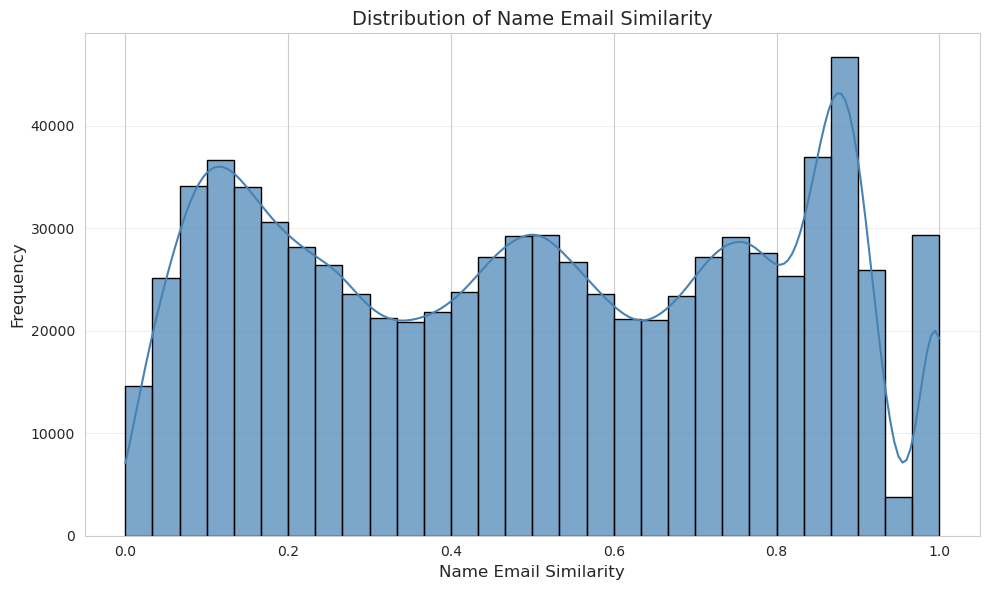

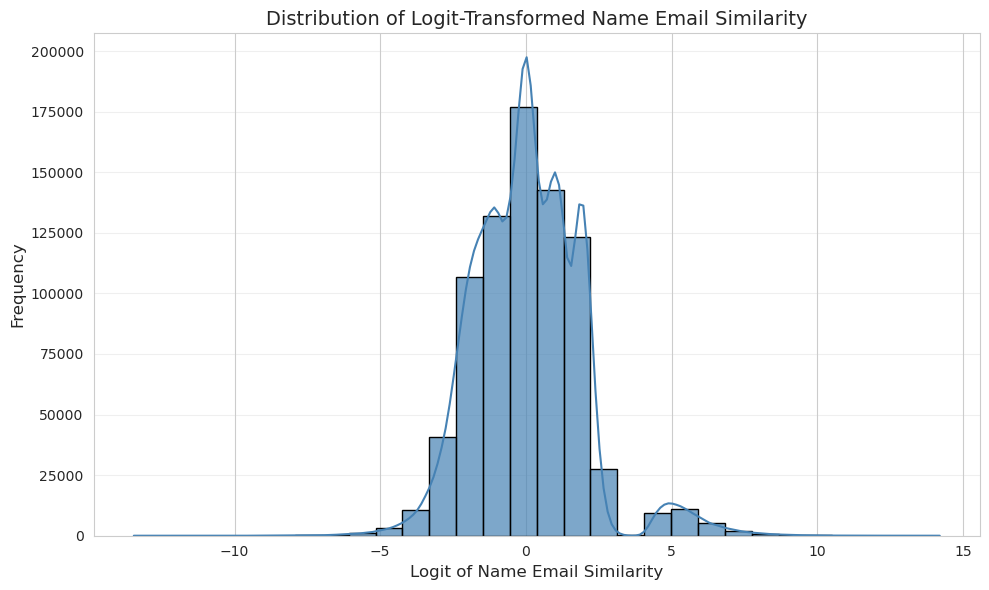

In [95]:
# Visualise through histogram the values of name_email_similarity continuous variable 
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset['name_email_similarity'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Name Email Similarity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Name Email Similarity', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Apply logit transformation
train_dataset['name_email_similarity_logit'] = np.log(train_dataset['name_email_similarity'] / (1 - train_dataset['name_email_similarity']))
# Visualise the logit-transformed values
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset['name_email_similarity_logit'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Logit of Name Email Similarity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Logit-Transformed Name Email Similarity', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Now the logit transformation seems more symmetrical and closer to the normal distribution. Also, the reason behind such transformation is due to the "stretching" of the distribution to a wider distribution and second, it can now separate better the customers with extreme similarity scores between each others such as between users with 0.9 and 1.0. However, this separation of such customers may be also noisy and thus both features (non logit and logit will be considered). **Even** many transformations such as target encoding after binning to a categorical feature, etc.. but not preferred such complex logics at this moment.

### **customer_age**

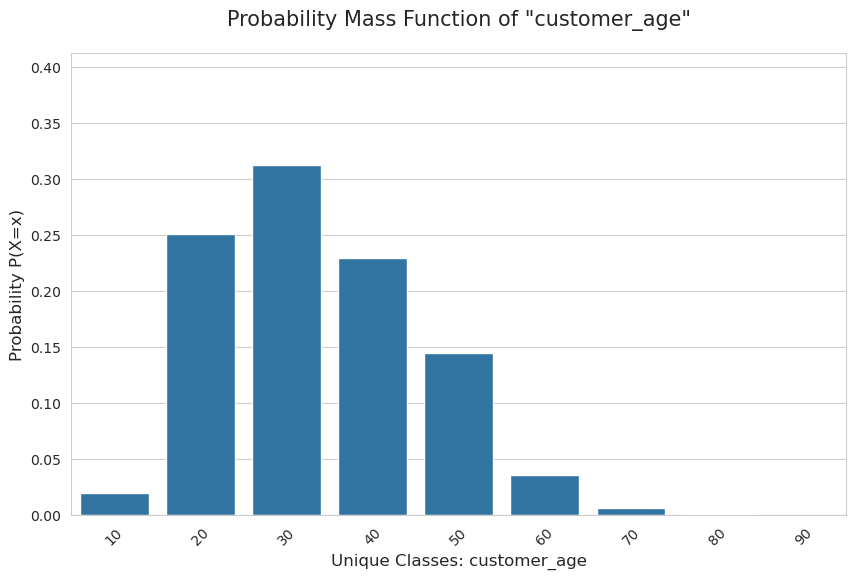

In [96]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = train_dataset["customer_age"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["customer_age", 'probability']

# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="customer_age", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "customer_age"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: customer_age', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()


**Consider target encoding in future.**

### **Days_since_request**

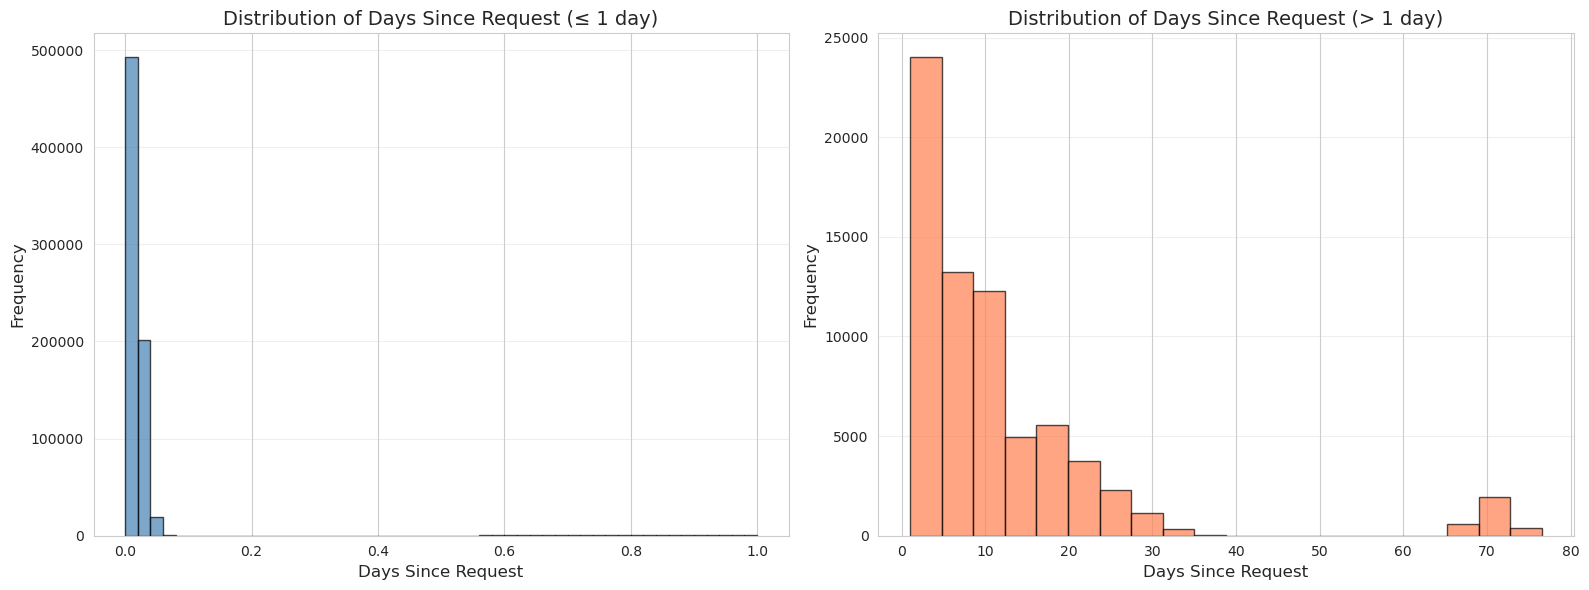

Recent requests (≤ 1 day): 724487 records (91.13%)
Older requests (> 1 day): 70502 records (8.87%)

Recent requests statistics:
count    7.244870e+05
mean     2.532734e-02
std      8.630278e-02
min      4.036860e-09
25%      6.575301e-03
50%      1.374746e-02
75%      2.297428e-02
max      9.999127e-01
Name: days_since_request, dtype: float64

Older requests statistics:
count    70502.000000
mean        11.754042
std         14.164896
min          1.000005
25%          2.966356
50%          8.182234
75%         14.968462
max         76.581477
Name: days_since_request, dtype: float64


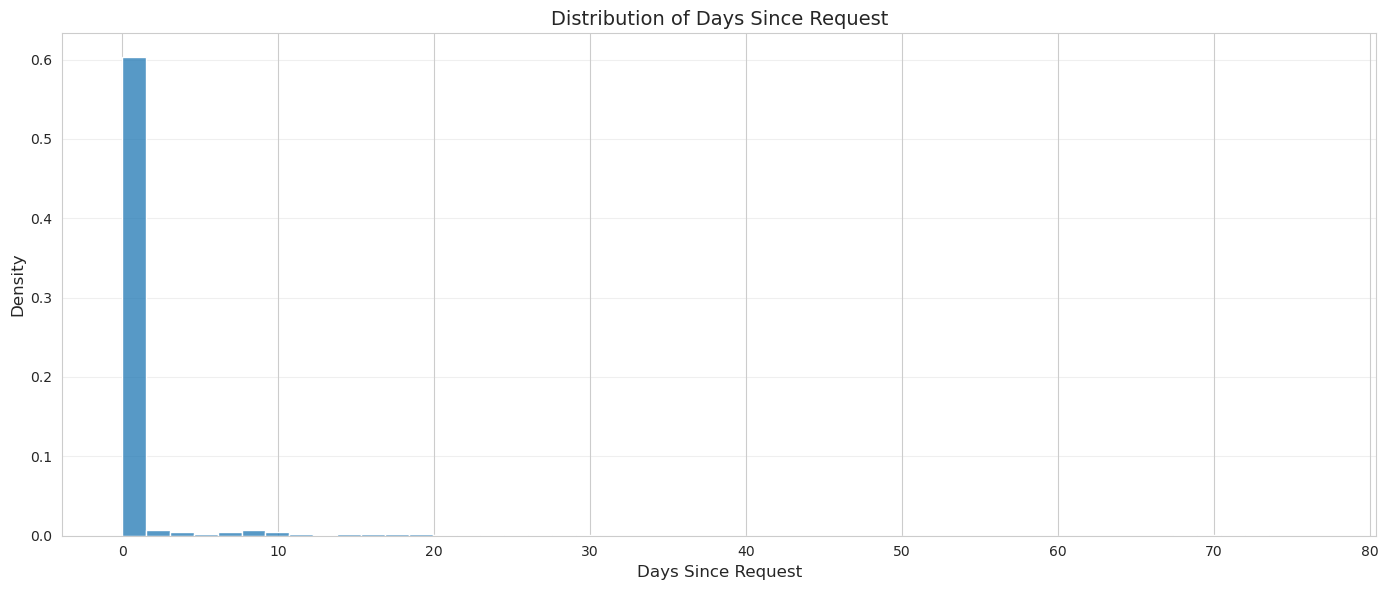

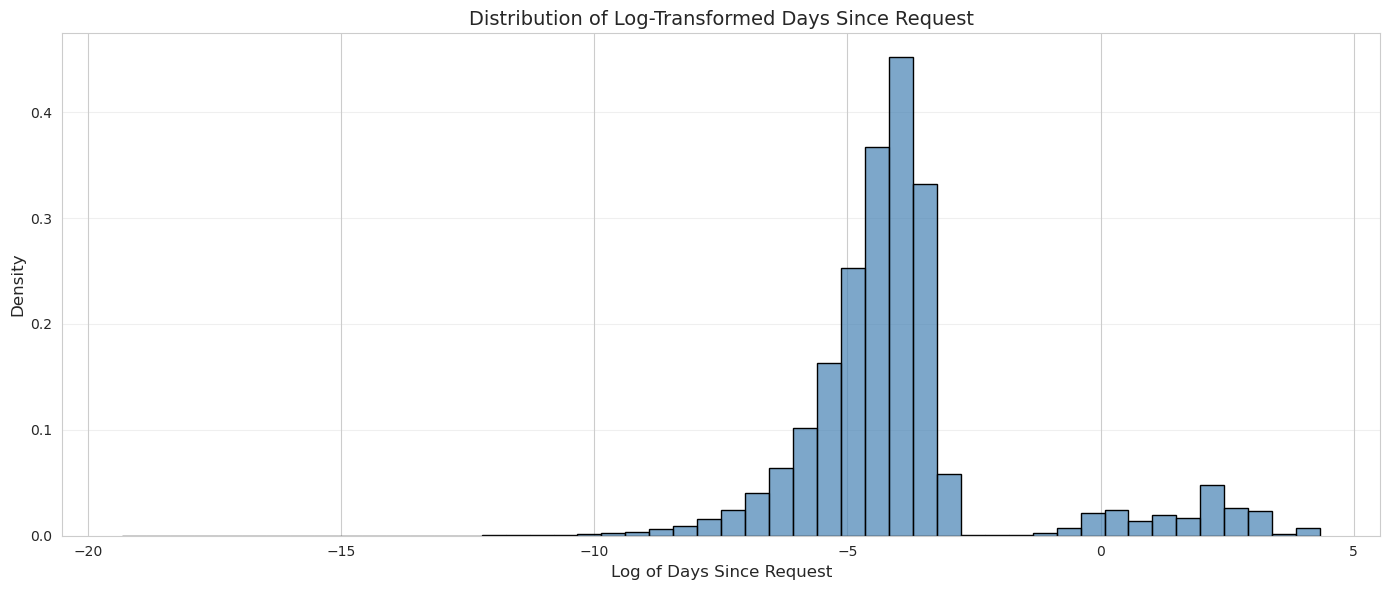

In [97]:
# Visualise through histogram the days_since_request. Visualise clear the distribution until days_since_request==1 and for the remaining use much wider bins since they are more rare values

# Split data into two regions: days_since_request <= 1 and > 1
data_recent = train_dataset[train_dataset['days_since_request'] <= 1]['days_since_request']
data_older = train_dataset[train_dataset['days_since_request'] > 1]['days_since_request']

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Recent requests (days_since_request <= 1) with fine bins
axes[0].hist(data_recent, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Days Since Request', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Days Since Request (≤ 1 day)', fontsize=14)
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Older requests (days_since_request > 1) with wider bins
axes[1].hist(data_older, bins=20, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Days Since Request', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Days Since Request (> 1 day)', fontsize=14)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Recent requests (≤ 1 day): {len(data_recent)} records ({len(data_recent)/len(train_dataset)*100:.2f}%)")
print(f"Older requests (> 1 day): {len(data_older)} records ({len(data_older)/len(train_dataset)*100:.2f}%)")
print(f"\nRecent requests statistics:\n{data_recent.describe()}")
print(f"\nOlder requests statistics:\n{data_older.describe()}")


# Visualise through histogram the days_since_request. Visualise clear the distribution until days_since_request==1 and for the remaining use much wider bins since they are more rare values
plt.figure(figsize=(14, 6))
sns.histplot(data=train_dataset, x='days_since_request', bins=50,  stat='density')
plt.xlabel('Days Since Request', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution of Days Since Request', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

train_dataset["days_since_request"].quantile([0.001,0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
# Calculate log-transformed days_since_request
train_dataset['days_since_request_log'] = np.log(train_dataset['days_since_request'])
# Visualise the log-transformed values from negative to positive x-axis values
plt.figure(figsize=(14, 6))
sns.histplot(data=train_dataset, x='days_since_request_log', bins=50, stat='density', color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Log of Days Since Request', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution of Log-Transformed Days Since Request', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [98]:
# Split data into three categories (days=[0,1]-->"Immediate", 1<days<=7 implies "Standard", >7 implies "Delayed")

train_dataset["days_since_request_binned"] = np.where(train_dataset["days_since_request"]<=1, "Immediate", np.where((train_dataset["days_since_request"]>1) & (train_dataset["days_since_request"]<=7), "Standard", "Delayed"))

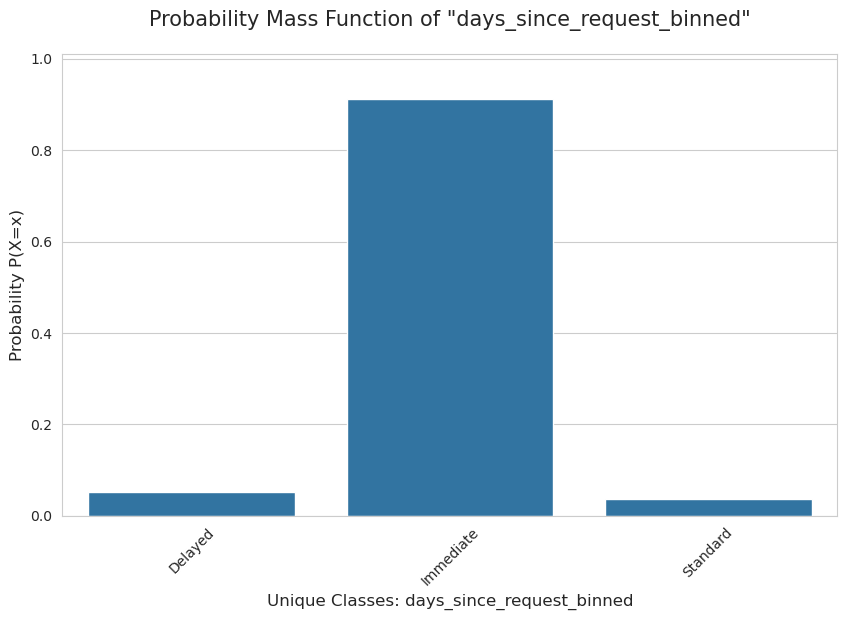

,days_since_request_binned,probability
0,Delayed,0.051708
1,Immediate,0.911317
2,Standard,0.036975


In [99]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = train_dataset["days_since_request_binned"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["days_since_request_binned", 'probability']

# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="days_since_request_binned", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "days_since_request_binned"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: days_since_request_binned', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
# Proportions
prob_df


### **intended_balcon_amount**

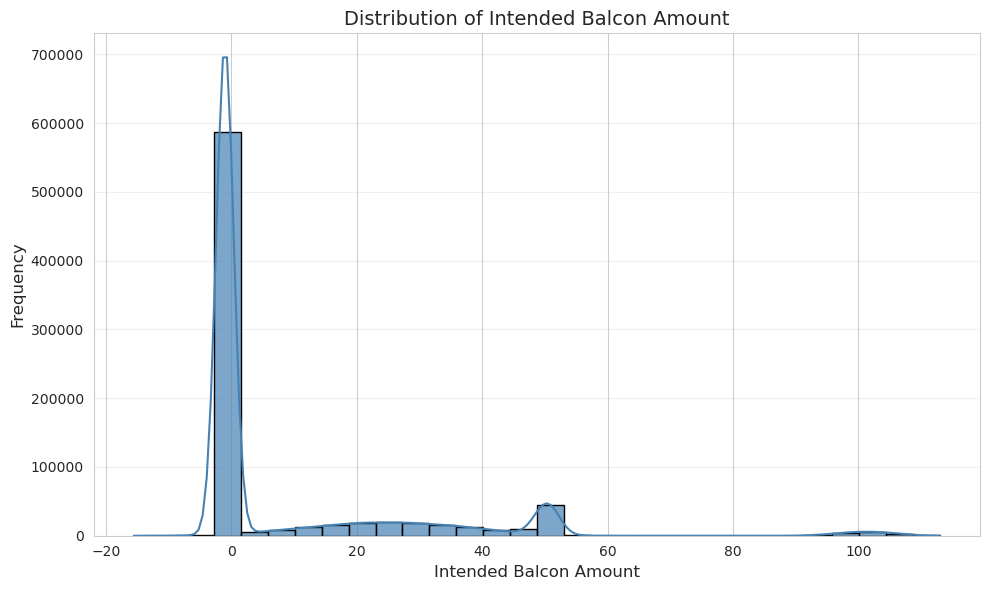

Descriptive statistics of intended_balcon_amount: 
count    794989.000000
mean          8.908110
std          20.431613
min         -15.530555
25%          -1.172497
50%          -0.818856
75%           7.644076
max         112.956928
Name: intended_balcon_amount, dtype: float64
Proportions of binary validation feature of valid transferred amount: 
valid_transferred_amount
missing    0.737001
Valid      0.262999
Name: proportion, dtype: float64
quantiles: 
0.001     -4.213110
0.250     -1.172497
0.500     -0.818856
0.750      7.644076
0.800     20.134964
0.850     29.014115
0.900     40.593320
0.950     50.484343
0.990    101.003219
Name: intended_balcon_amount, dtype: float64


In [100]:
# Visualualize the distribution of intended_balcon_amount using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset['intended_balcon_amount'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Intended Balcon Amount', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Intended Balcon Amount', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
print(f"Descriptive statistics of intended_balcon_amount: \n{train_dataset['intended_balcon_amount'].describe()}")
# Apply binning to missing or non missing
train_dataset["valid_transferred_amount"]=np.where(train_dataset["intended_balcon_amount"]<0,"missing","Valid")
print(f"Proportions of binary validation feature of valid transferred amount: \n{train_dataset['valid_transferred_amount'].value_counts(normalize=True)}")
print(f"quantiles: \n{train_dataset['intended_balcon_amount'].quantile([0.001,0.25, 0.5, 0.75,0.8,0.85, 0.9, 0.95, 0.99])}")



Apply a decision tree classifier with specific main hyper-parameter values will help us find the best cut-off points to create meaningful bins in terms of how they affect the fraud rate.

In [101]:
from sklearn.tree import DecisionTreeClassifier

# We use a slightly higher depth but strict leaf requirements
dt_binning = DecisionTreeClassifier(
    max_depth=2, 
    min_samples_leaf=0.05, # Each bin must have at least 5% of data
    random_state=42
)
x = train_dataset.loc[dataset['intended_balcon_amount'] > 0, 'intended_balcon_amount'].values.reshape(-1, 1)
y = train_dataset.loc[dataset['intended_balcon_amount'] > 0, 'fraud_bool'].values
# Fit on training data only to avoid leakage
dt_binning.fit(x, y)

# The 'thresholds' will now respect your quantile spikes (0, 50, 100)
thresholds = dt_binning.tree_.threshold
print(f"Optimal bin boundaries found: {thresholds[thresholds != -2]}")

Optimal bin boundaries found: [92.11457062 51.45923233]


Create now the categorical feature of intended_balcon_amount

In [102]:
train_dataset["intended_balcon_amount_binned"] = pd.cut(train_dataset['intended_balcon_amount'], bins=[-np.inf, 0,  52,92, np.inf], labels=['Missing/Negative', '0-52', '52-92', '92+'])

### payment_type

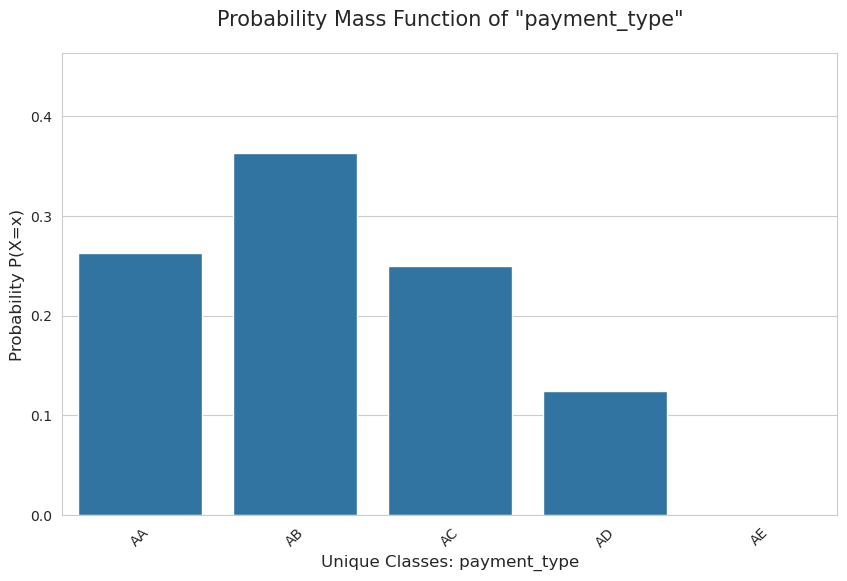

,payment_type,probability
0,AA,0.262796
1,AB,0.362498
2,AC,0.249788
3,AD,0.124605
4,AE,0.000312


In [103]:
train_dataset["payment_type"].value_counts()
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = train_dataset["payment_type"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["payment_type", 'probability']

# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="payment_type", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "payment_type"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: payment_type', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
# Proportions
prob_df

**Class AE** should be combined with others based on the influence on the target variable and the distribution of the data. If Class AE has a very small number of instances or if it does not show a significant difference in the target variable compared to other classes, it may be beneficial to combine it with a similar class to improve model performance and reduce noise (next notebook).

### zip_count_4w

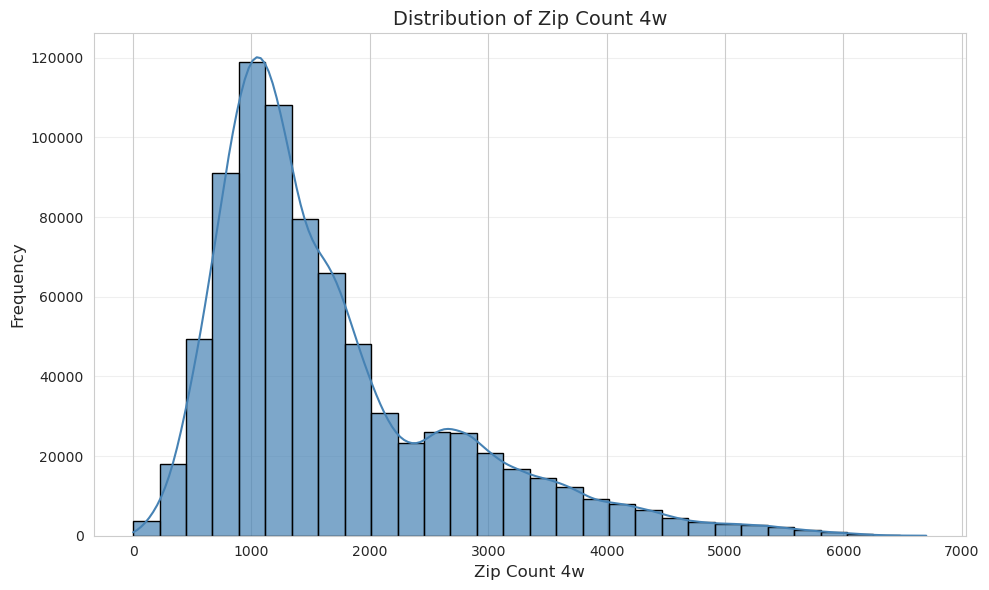

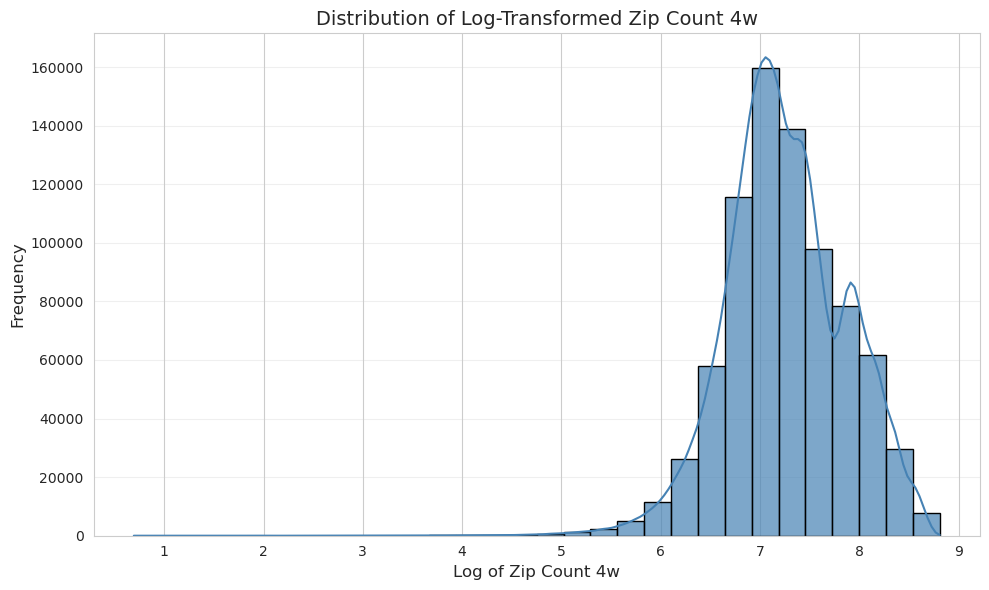

In [104]:
# Visualise the histogram of zip_count_4w 
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset['zip_count_4w'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Zip Count 4w', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Zip Count 4w', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
# Log transform zip_count_4w to reduce skewness
train_dataset['zip_count_4w_log'] = np.log1p(train_dataset['zip_count_4w'])
# Visualise the log-transformed values
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset['zip_count_4w_log'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Log of Zip Count 4w', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Log-Transformed Zip Count 4w', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()  
plt.show()

**Remove unnecessary variable of raw zip count**

In [105]:
train_dataset.drop(columns={"zip_count_4w"}, inplace=True)

### velocity_6h

In [106]:
train_dataset['velocity_6h'].describe()

count    794989.000000
mean       6148.453005
std        3013.664048
min        -130.456928
25%        3971.401783
50%        5961.190608
75%        8113.534146
max       16715.565404
Name: velocity_6h, dtype: float64

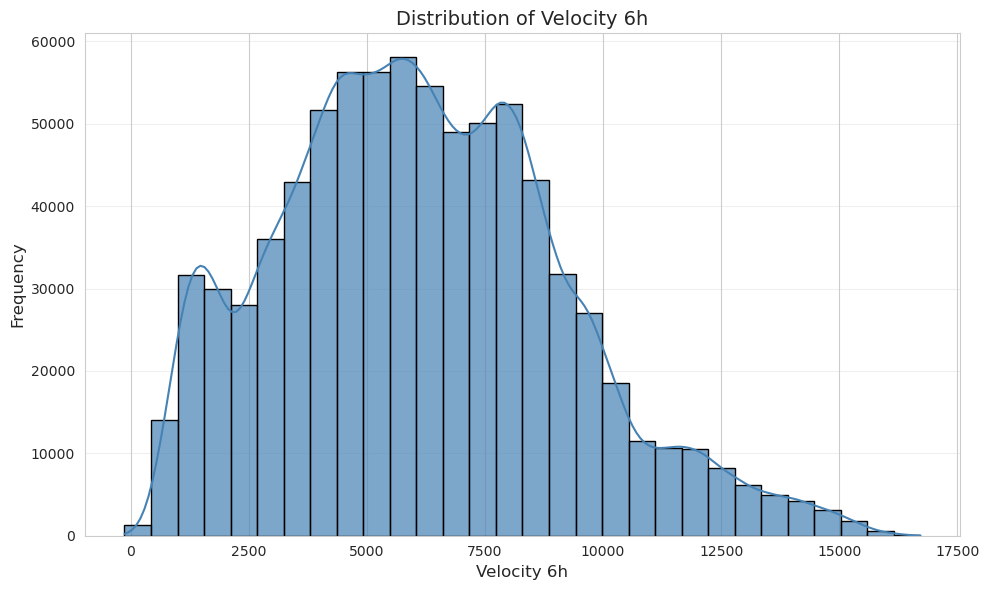

/home/codespace/miniforge3/envs/mlops/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


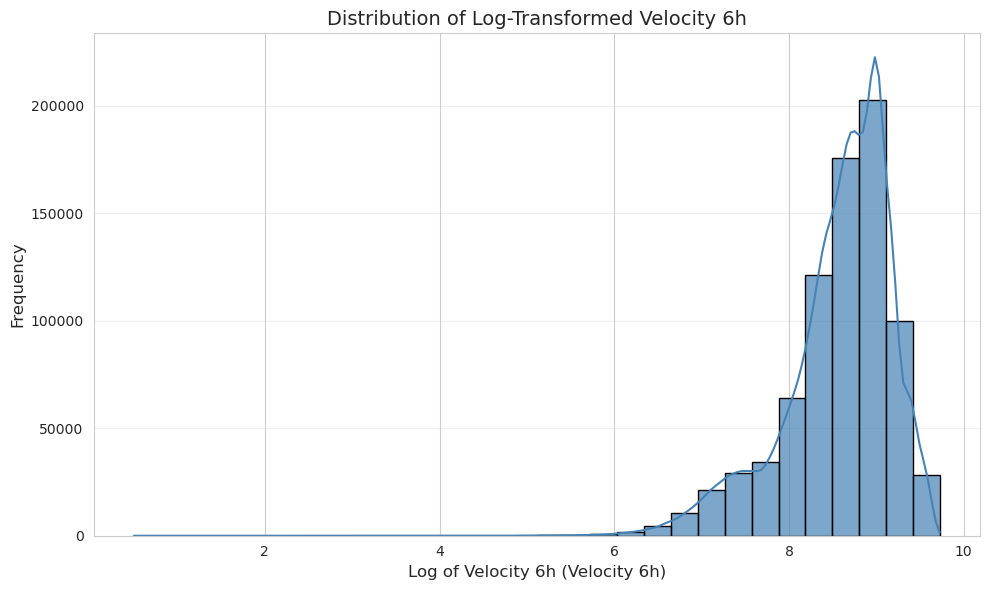

In [107]:
# Visualise the histogram of zip_count_4w 
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset['velocity_6h'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Velocity 6h', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Velocity 6h', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
# Log transform zip_count_4w to reduce skewness
train_dataset['velocity_6h_log'] =train_dataset['velocity_6h']
train_dataset['velocity_6h_log']=np.where(train_dataset['velocity_6h']>0, np.log1p(train_dataset['velocity_6h']), train_dataset['velocity_6h'])
# Visualise the log-transformed values
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset.loc[train_dataset['velocity_6h'] > 0, 'velocity_6h_log'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Log of Velocity 6h (Velocity 6h)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Log-Transformed Velocity 6h', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()  
plt.show()

**Need to impute missing value first** and then apply log.

In [108]:
train_dataset["velocity_6h_valid"]=np.where(train_dataset["velocity_6h"]<0,"missing","Valid")
train_dataset["velocity_6h_valid"].value_counts(normalize=True)

velocity_6h_valid
Valid      0.999975
missing    0.000025
Name: proportion, dtype: float64

### Velocity 24h

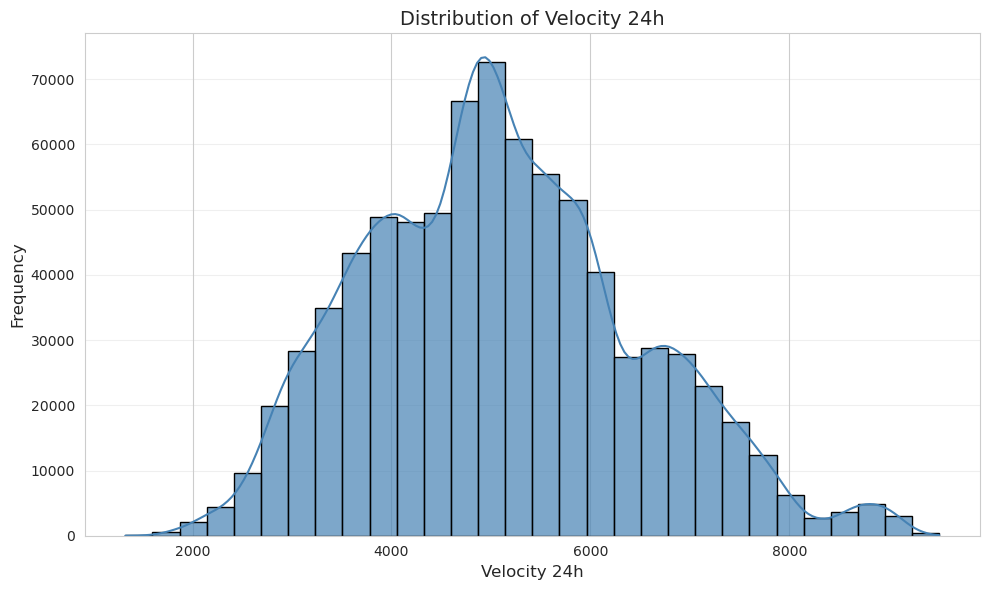

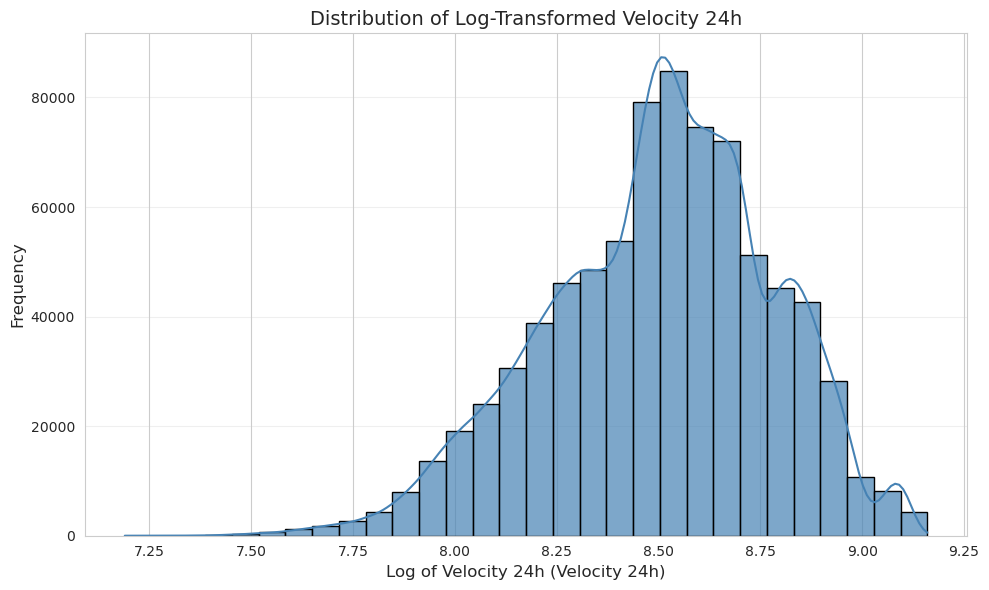

In [109]:
# Visualise the histogram of zip_count_4w 
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset['velocity_24h'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Velocity 24h', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Velocity 24h', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
# Log transform zip_count_4w to reduce skewness
train_dataset['velocity_24h_log'] =train_dataset['velocity_24h']
train_dataset['velocity_24h_log']=np.where(train_dataset['velocity_24h']>0, np.log1p(train_dataset['velocity_24h']), train_dataset['velocity_24h'])
# Visualise the log-transformed values
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset['velocity_24h_log'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Log of Velocity 24h (Velocity 24h)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Log-Transformed Velocity 24h', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()  
plt.show()

### Velocity 4w

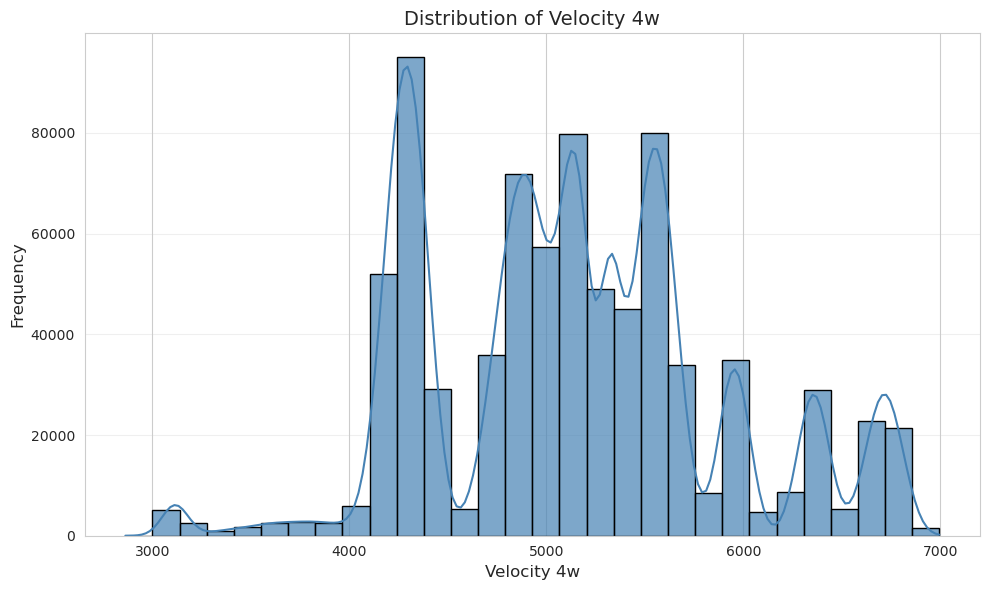

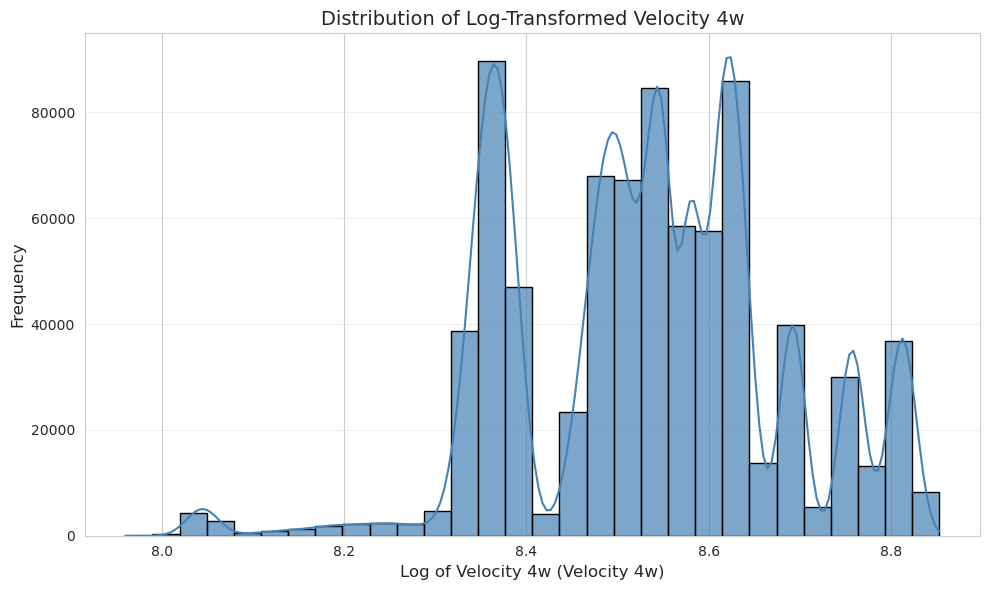

In [110]:
# Visualise the histogram of zip_count_4w 
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset['velocity_4w'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Velocity 4w', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Velocity 4w', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
# Log transform zip_count_4w to reduce skewness
train_dataset['velocity_4w_log'] =train_dataset['velocity_4w']
train_dataset['velocity_4w_log']=np.where(train_dataset['velocity_4w']>0, np.log1p(train_dataset['velocity_4w']), train_dataset['velocity_4w'])
# Visualise the log-transformed values
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset['velocity_4w_log'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Log of Velocity 4w (Velocity 4w)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Log-Transformed Velocity 4w', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()  
plt.show()

### **bank_branch_count_8w**

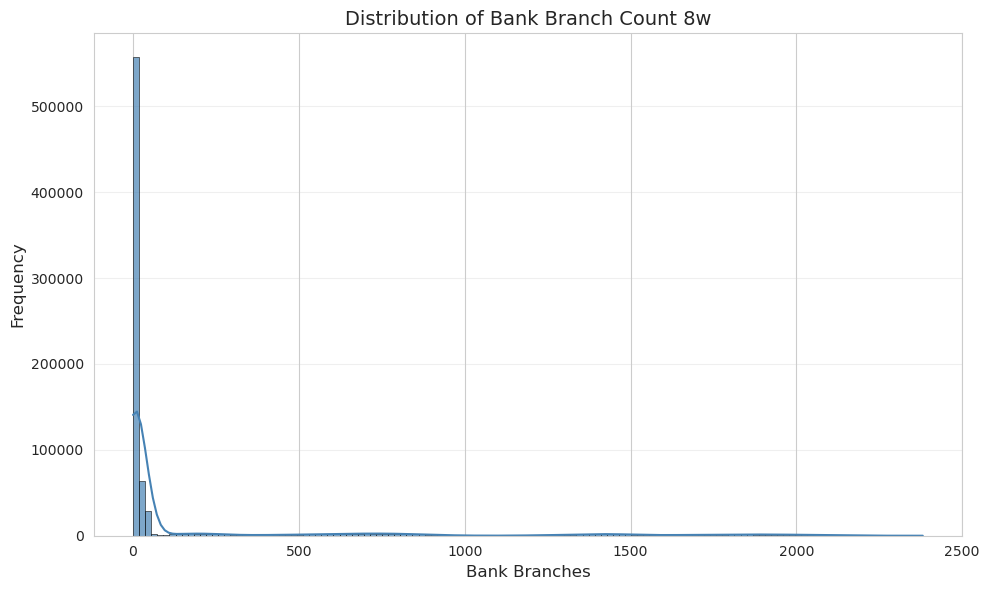

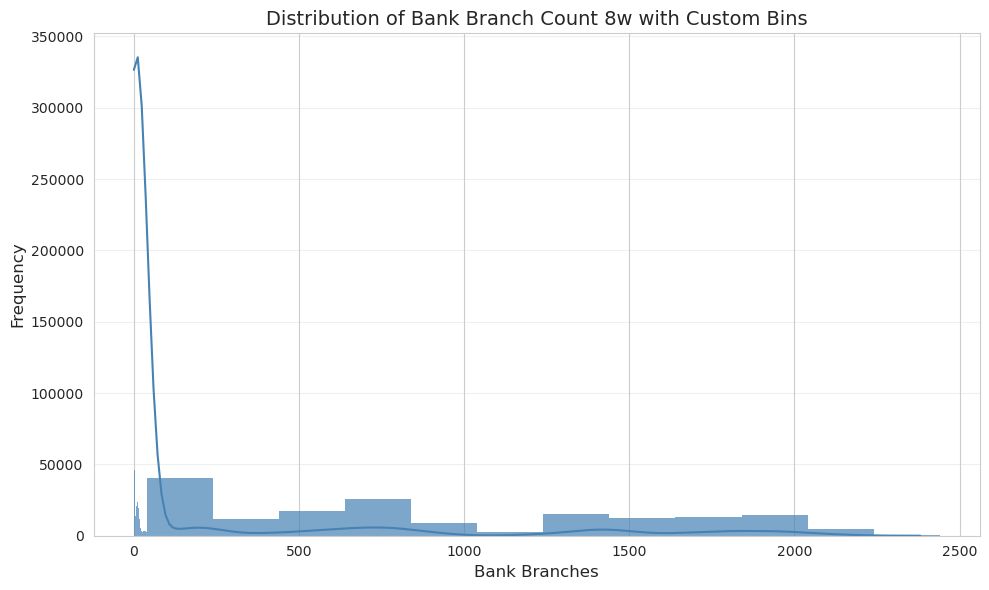

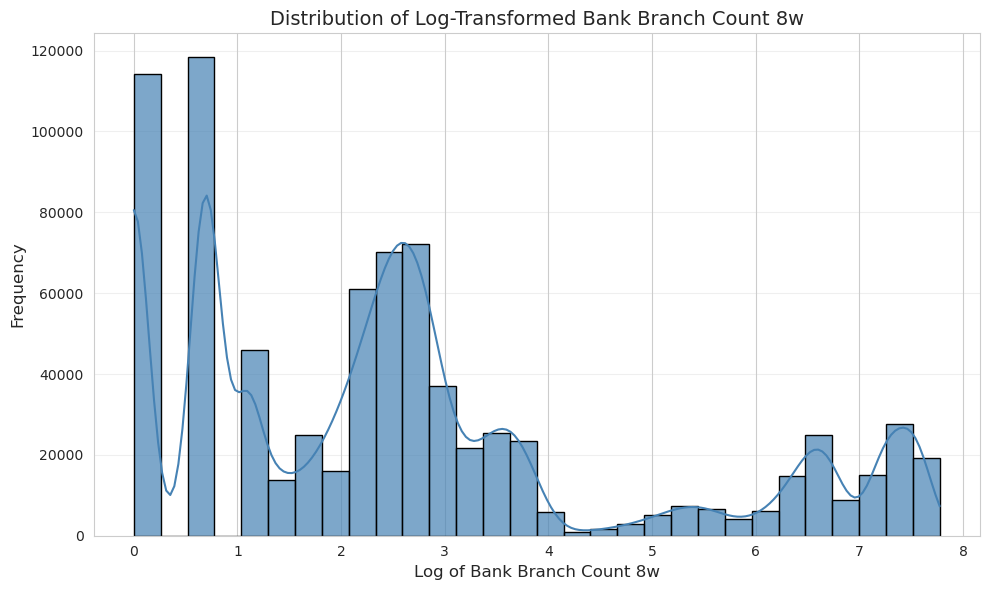

Quantiles of bank_branch_count_8w: 
0.001       0.0
0.250       1.0
0.500      10.0
0.750      29.0
0.900     768.0
0.950    1488.0
0.990    1985.0
Name: bank_branch_count_8w, dtype: float64


In [111]:
# Visualise the histogram of zip_count_4w 
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset['bank_branch_count_8w'], bins=130, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Bank Branches', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Bank Branch Count 8w', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
# Create custom bins
narrow_bins = np.arange(0, 41, 1)  # Bins from 0 to 40 with a width of 1
wide_bins = np.arange(40, train_dataset['bank_branch_count_8w'].max() + 200, 200)  # Bins from 40 to max with a width of
combined_bins = np.concatenate((narrow_bins, wide_bins))
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset['bank_branch_count_8w'], bins=combined_bins, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Bank Branches', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Bank Branch Count 8w with Custom Bins', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
# log transform bank_branch_count_8w to reduce skewness
train_dataset['bank_branch_count_8w_log'] = np.log1p(train_dataset['bank_branch_count_8w'])
# Visualise the log-transformed values
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset['bank_branch_count_8w_log'], bins=30, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Log of Bank Branch Count 8w', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Log-Transformed Bank Branch Count 8w', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()  
plt.show()

# Print the quantiles of bank_branch_count_8w to understand the distribution and the presence of outliers
print(f"Quantiles of bank_branch_count_8w: \n{train_dataset['bank_branch_count_8w'].quantile([0.001,0.25, 0.5, 0.75, 0.9, 0.95, 0.99])}")

In [112]:
train_dataset['bank_branch_count_8w'].describe()
train_dataset['bank_branch_count_8w'].quantile([0.001,0.25, 0.5, 0.75,0.8,0.85, 0.9, 0.95, 0.99])
# Discretise bank_branch_count_8w into bins based on quantiles (e.g. 80th quantile, 85th, 90th, 95th, 100th)
train_dataset['bank_branch_count_8w_binned'] = pd.cut(train_dataset['bank_branch_count_8w'], bins=[-1, train_dataset['bank_branch_count_8w'].quantile(0.8), train_dataset['bank_branch_count_8w'].quantile(0.85), train_dataset['bank_branch_count_8w'].quantile(0.9), train_dataset['bank_branch_count_8w'].quantile(0.95), train_dataset['bank_branch_count_8w'].max()], labels=['<=42', '<315', '<=768', '<=1488', '>1488'])

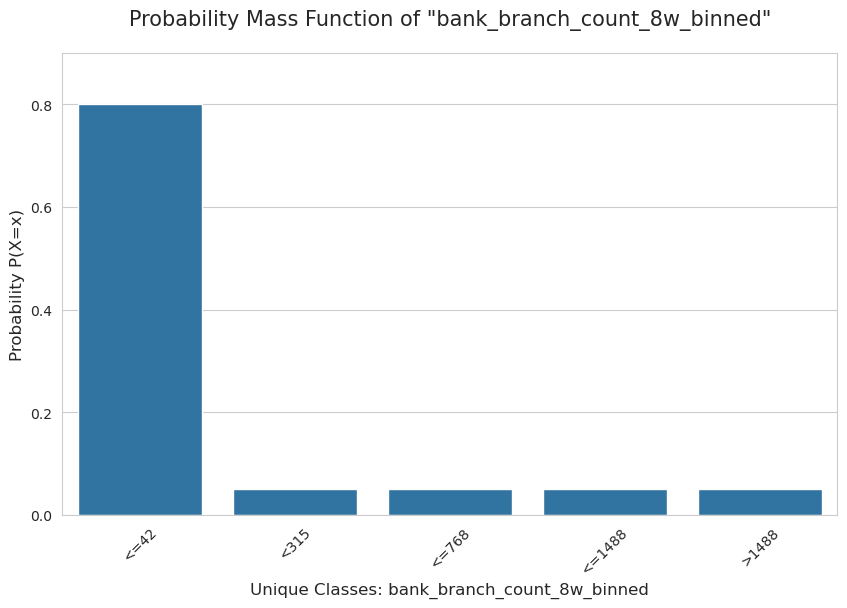

In [113]:
train_dataset["bank_branch_count_8w_binned"].value_counts()
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = train_dataset["bank_branch_count_8w_binned"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["bank_branch_count_8w_binned", 'probability']

# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="bank_branch_count_8w_binned", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "bank_branch_count_8w_binned"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: bank_branch_count_8w_binned', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()

### date_of_birth_distinct_emails_4w

In [114]:
train_dataset['date_of_birth_distinct_emails_4w'].describe()

count    794989.000000
mean          9.995106
std           5.165063
min           0.000000
25%           6.000000
50%           9.000000
75%          13.000000
max          39.000000
Name: date_of_birth_distinct_emails_4w, dtype: float64

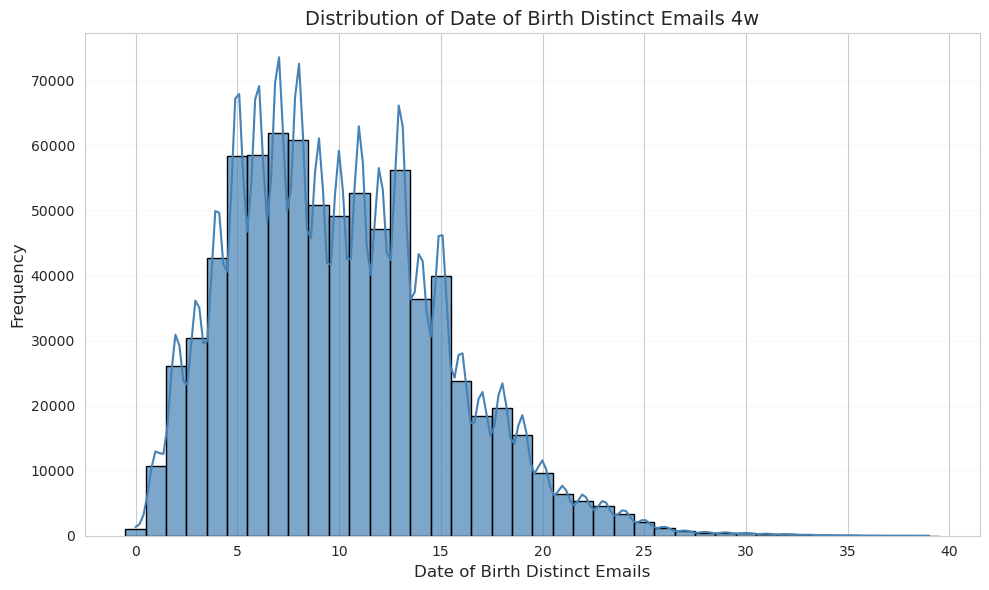

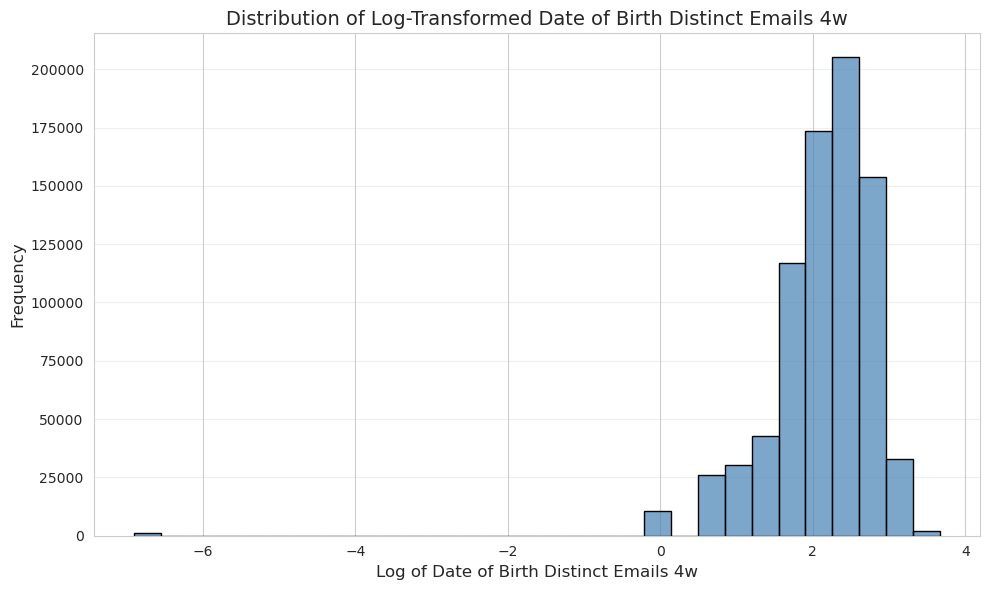

/home/codespace/miniforge3/envs/mlops/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


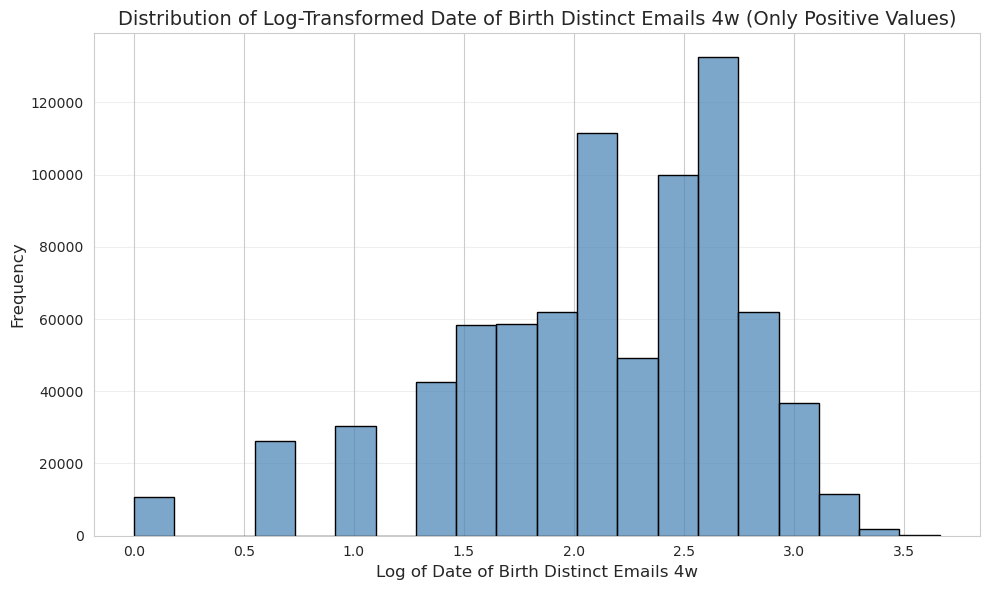

In [115]:
# Visualise the histogram of zip_count_4w 
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset['date_of_birth_distinct_emails_4w'], bins=40, kde=True, color='steelblue', edgecolor='black', alpha=0.7,discrete=True)
plt.xlabel('Date of Birth Distinct Emails', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Date of Birth Distinct Emails 4w', fontsize=14)
plt.grid(axis='y', alpha=0.1)
plt.tight_layout()
plt.show()
# Log transform date_of_birth_distinct_emails_4w to reduce skewness
train_dataset['date_of_birth_distinct_emails_4w_log'] = np.log(train_dataset['date_of_birth_distinct_emails_4w']+0.001)
# Visualise the log-transformed values
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset['date_of_birth_distinct_emails_4w_log'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Log of Date of Birth Distinct Emails 4w', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Log-Transformed Date of Birth Distinct Emails 4w', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()  
plt.show()
# Log transform only the positive values of date_of_birth_distinct_emails_4w
train_dataset['date_of_birth_distinct_emails_4w_log_original'] = np.log(train_dataset['date_of_birth_distinct_emails_4w'])

# Visualise the log-transformed values
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset.loc[train_dataset['date_of_birth_distinct_emails_4w'] > 0, 'date_of_birth_distinct_emails_4w_log_original'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Log of Date of Birth Distinct Emails 4w', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Log-Transformed Date of Birth Distinct Emails 4w (Only Positive Values)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()  
plt.show()

### employment_status

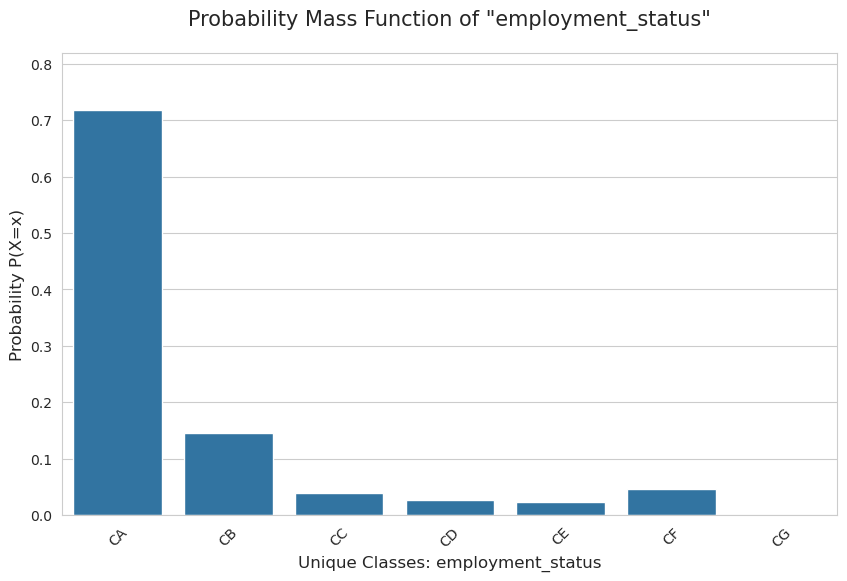

Proportions of employment_status: 
employment_status
CA    0.718932
CB    0.145222
CF    0.045572
CC    0.039305
CD    0.027680
CE    0.022822
CG    0.000468
Name: proportion, dtype: float64


In [116]:
train_dataset["employment_status"].value_counts()
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = train_dataset["employment_status"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["employment_status", 'probability']

# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="employment_status", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "employment_status"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: employment_status', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
print(f"Proportions of employment_status: \n{train_dataset['employment_status'].value_counts(normalize=True)}")

Many classes should be combined later on based on how they affect the target variable.

### credit_risk_score

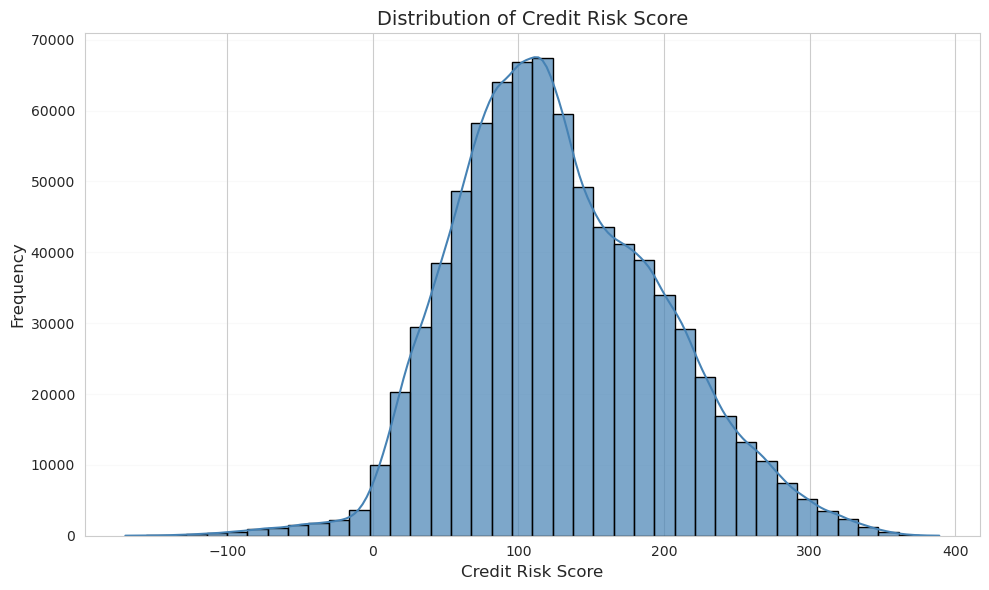

In [117]:
# Visualise the histogram of zip_count_4w 
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset['credit_risk_score'], bins=40, kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Credit Risk Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Credit Risk Score', fontsize=14)
plt.grid(axis='y', alpha=0.1)
plt.tight_layout()
plt.show()

### e-mail_is_free

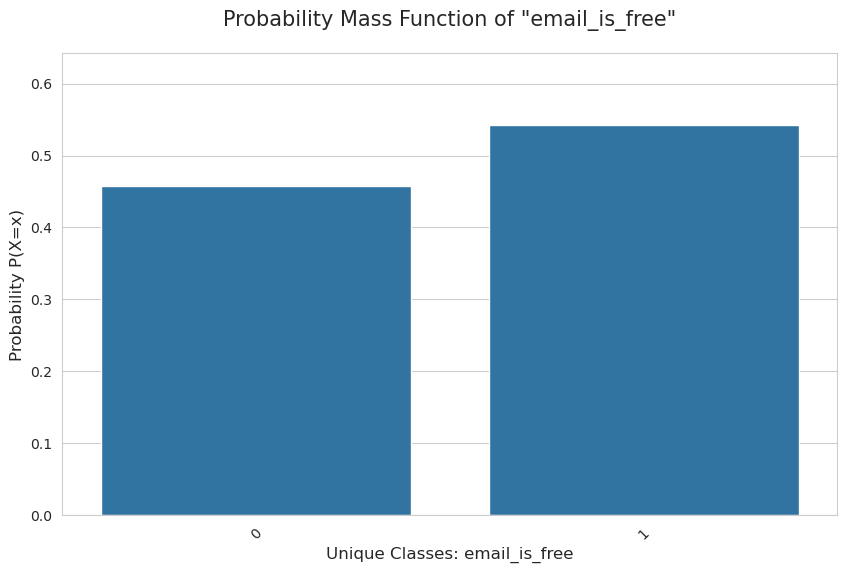

In [118]:
train_dataset["email_is_free"].value_counts()
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = train_dataset["email_is_free"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["email_is_free", 'probability']

# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="email_is_free", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "email_is_free"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: email_is_free', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()

### housing_status

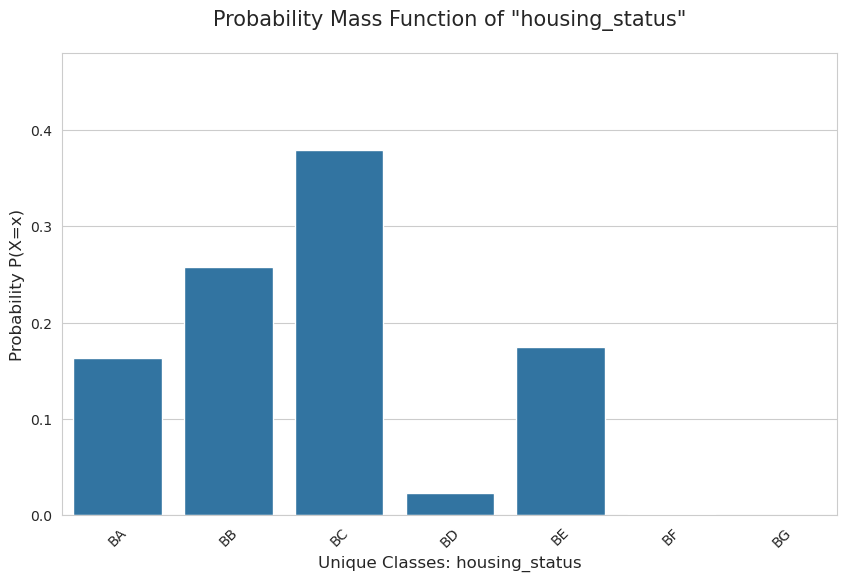

housing_status
BC    0.379727
BB    0.257349
BE    0.175108
BA    0.163241
BD    0.022586
BF    0.001708
BG    0.000279
Name: count, dtype: float64

In [119]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = train_dataset["housing_status"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["housing_status", 'probability']
# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="housing_status", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "housing_status"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: housing_status', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
train_dataset["housing_status"].value_counts()/len(train_dataset)


**Inference**: Some categories can be combined to Other such as BG, BF, BD

In [120]:
# Create an engineered housing_status_engineered column where we group BG, BF, BD as 'Other' and keep the rest as is.

train_dataset['housing_status_engineered']=np.where(train_dataset["housing_status"].isin(['BG', 'BF', 'BD']),'Other',train_dataset["housing_status"])

### phone_home_valid, phone_mobile_valid

In [121]:
train_dataset["phone_home_valid"]=np.where(train_dataset["phone_home_valid"]==1, "Valid", "Invalid")
train_dataset["phone_mobile_valid"]=np.where(train_dataset["phone_mobile_valid"]==1, "Valid", "Invalid")
train_dataset["phone_home_and_mobile_valid"]=train_dataset["phone_home_valid"]+"_"+train_dataset["phone_mobile_valid"]

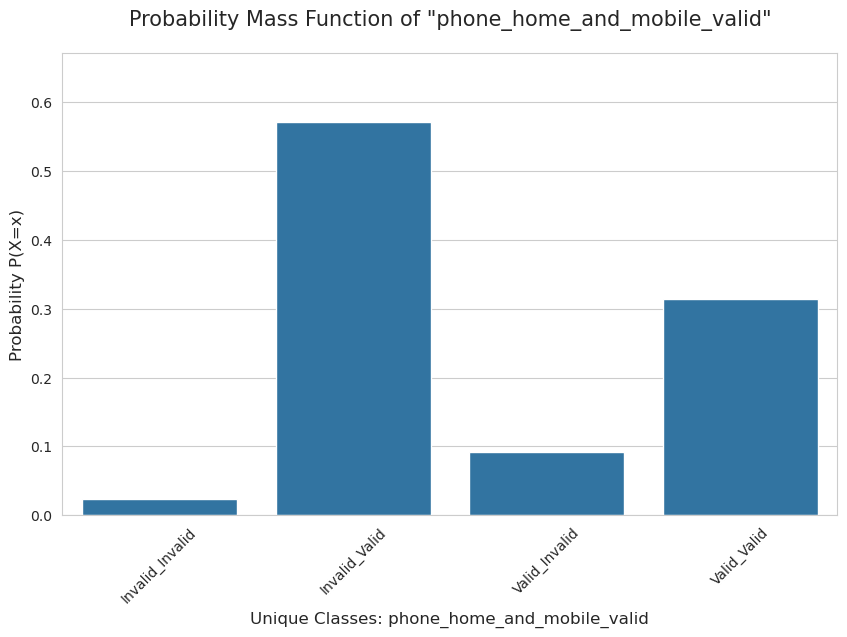

phone_home_and_mobile_valid
Invalid_Valid      0.571453
Valid_Valid        0.313679
Valid_Invalid      0.091158
Invalid_Invalid    0.023710
Name: count, dtype: float64

In [122]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = train_dataset["phone_home_and_mobile_valid"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["phone_home_and_mobile_valid", 'probability']
# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="phone_home_and_mobile_valid", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "phone_home_and_mobile_valid"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: phone_home_and_mobile_valid', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
train_dataset["phone_home_and_mobile_valid"].value_counts()/len(train_dataset)


### proposed_credit_limit

In [123]:
train_dataset['proposed_credit_limit'].quantile(np.arange(0, 1.01, 0.025))

0.000     190.0
0.025     200.0
0.050     200.0
0.075     200.0
0.100     200.0
0.125     200.0
0.150     200.0
0.175     200.0
0.200     200.0
0.225     200.0
0.250     200.0
0.275     200.0
0.300     200.0
0.325     200.0
0.350     200.0
0.375     200.0
0.400     200.0
0.425     200.0
0.450     200.0
0.475     200.0
0.500     200.0
0.525     200.0
0.550     200.0
0.575     200.0
0.600     200.0
0.625     500.0
0.650     500.0
0.675     500.0
0.700     500.0
0.725     500.0
0.750     510.0
0.775    1000.0
0.800    1000.0
0.825    1000.0
0.850    1500.0
0.875    1500.0
0.900    1500.0
0.925    1500.0
0.950    1500.0
0.975    1500.0
1.000    2100.0
Name: proposed_credit_limit, dtype: float64

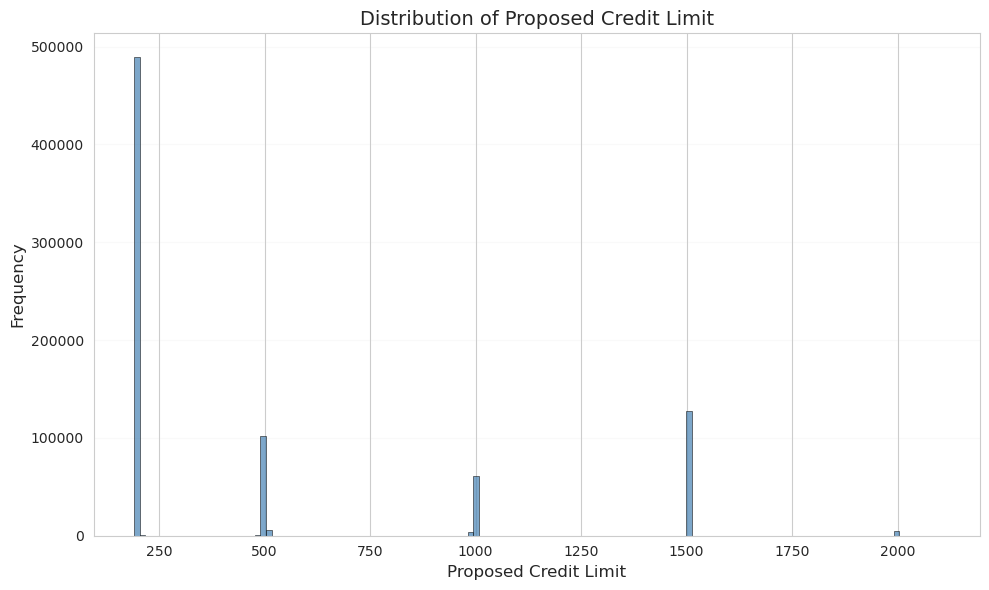

proposed_credit_limit
200.0     488926
1500.0    127369
500.0     101502
1000.0     61077
510.0       6081
2000.0      4554
990.0       4220
210.0        552
490.0        377
1900.0       208
190.0         85
2100.0        38
Name: count, dtype: int64

In [124]:
# Visualise the histogram of zip_count_4w 
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset['proposed_credit_limit'], bins=140, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Proposed Credit Limit', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Proposed Credit Limit', fontsize=14)
plt.grid(axis='y', alpha=0.1)
plt.tight_layout()
plt.show()
train_dataset['proposed_credit_limit'].value_counts()


In [125]:
## Discretise bank_branch_count_8w into bins based on quantiles (e.g.60th quantile, 70th, 80th, 90th, 100th)
train_dataset['proposed_credit_limit_binned'] = pd.cut(train_dataset['proposed_credit_limit'], bins=[-1, train_dataset['proposed_credit_limit'].quantile(0.6), train_dataset['proposed_credit_limit'].quantile(0.8),  train_dataset['proposed_credit_limit'].max()], labels=['<=200', '200<x<=1000', '1000+'])

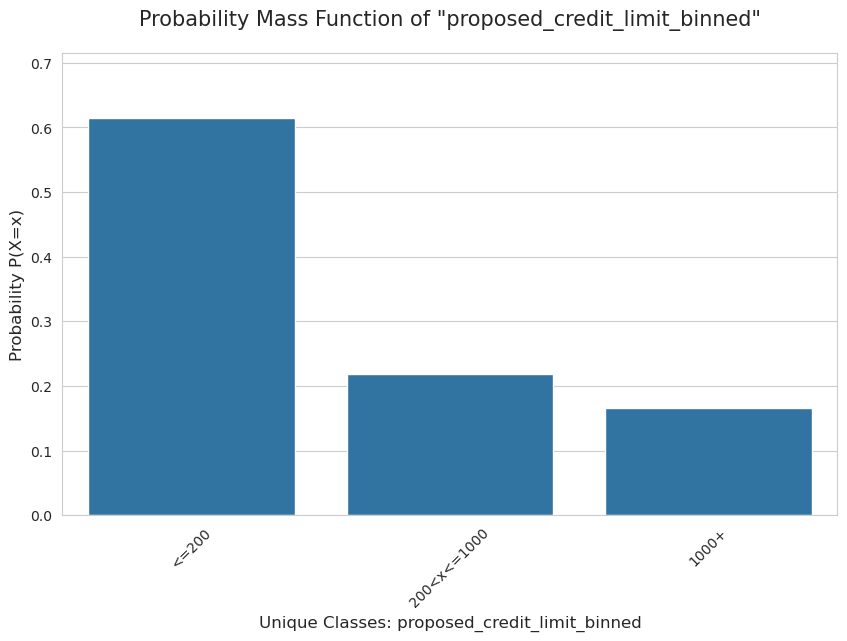

proposed_credit_limit_binned
<=200          0.615117
200<x<=1000    0.218631
1000+          0.166253
Name: count, dtype: float64

In [126]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = train_dataset["proposed_credit_limit_binned"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["proposed_credit_limit_binned", 'probability']
# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="proposed_credit_limit_binned", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "proposed_credit_limit_binned"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: proposed_credit_limit_binned', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
train_dataset["proposed_credit_limit_binned"].value_counts()/len(train_dataset)


### foreign_request

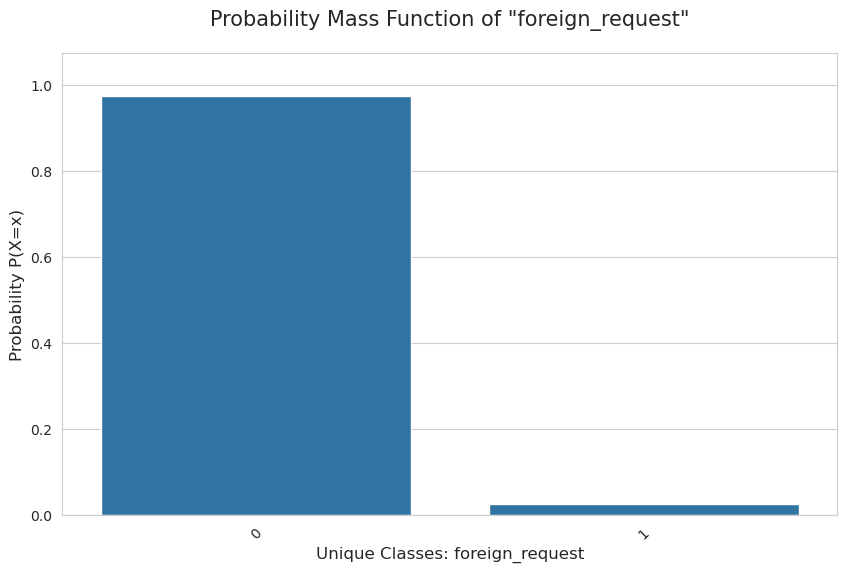

foreign_request
0    0.974758
1    0.025242
Name: count, dtype: float64

In [127]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = train_dataset["foreign_request"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["foreign_request", 'probability']
# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="foreign_request", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "foreign_request"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: foreign_request', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
dataset["foreign_request"].value_counts()/len(dataset)


### source

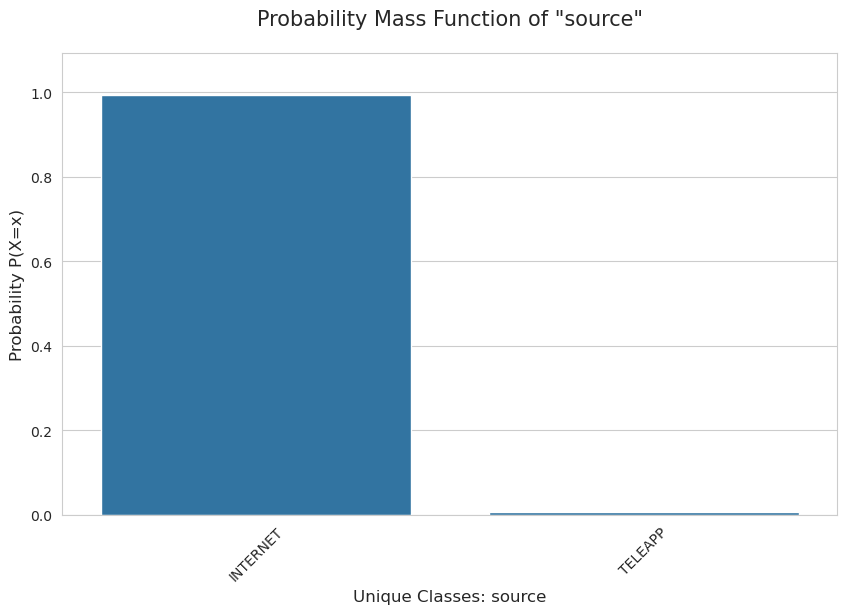

source
INTERNET    0.992784
TELEAPP     0.007216
Name: count, dtype: float64

In [128]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = train_dataset["source"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["source", 'probability']
# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="source", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "source"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: source', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
train_dataset["source"].value_counts()/len(train_dataset)


### session_length_in_minutes

In [129]:
train_dataset["session_length_in_minutes"].describe()
train_dataset["session_length_in_minutes"].quantile(np.arange(0.01,1,0.05))


0.01     0.701548
0.06     1.418010
0.11     1.863611
0.16     2.333040
0.21     2.861873
0.26     3.335563
0.31     3.743689
0.36     4.124857
0.41     4.500816
0.46     4.893522
0.51     5.316044
0.56     5.813309
0.61     6.425761
0.66     7.213483
0.71     8.138290
0.76     9.257993
0.81    10.842244
0.86    13.105598
0.91    16.876186
0.96    25.279933
Name: session_length_in_minutes, dtype: float64

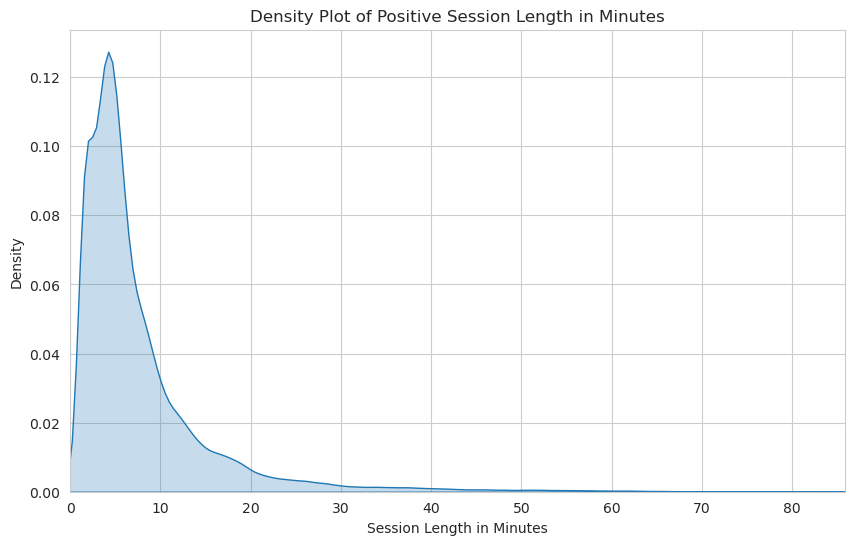

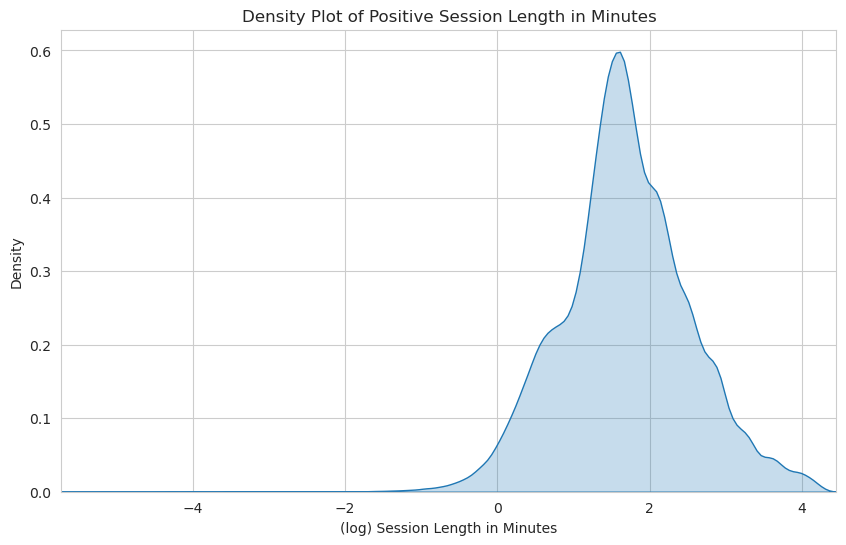

In [130]:
train_dataset[(train_dataset['session_length_in_minutes'] > 0) ]["session_length_in_minutes"].describe()
# Plot a density plot of session_length_in_minutes for positive values

positive_session_length = train_dataset[(train_dataset['session_length_in_minutes'] > 0) ]["session_length_in_minutes"]
plt.figure(figsize=(10,6))
sns.kdeplot(positive_session_length, fill=True)
plt.title('Density Plot of Positive Session Length in Minutes')
plt.xlabel('Session Length in Minutes')
plt.ylabel('Density')
plt.xlim(0, positive_session_length.max())
plt.show()

plt.figure(figsize=(10,6))
sns.kdeplot(np.log(positive_session_length), fill=True)
plt.title('Density Plot of Positive Session Length in Minutes')
plt.xlabel('(log) Session Length in Minutes')
plt.ylabel('Density')
plt.xlim(np.log(positive_session_length).min(), np.log(positive_session_length).max())
plt.show()

### device_os

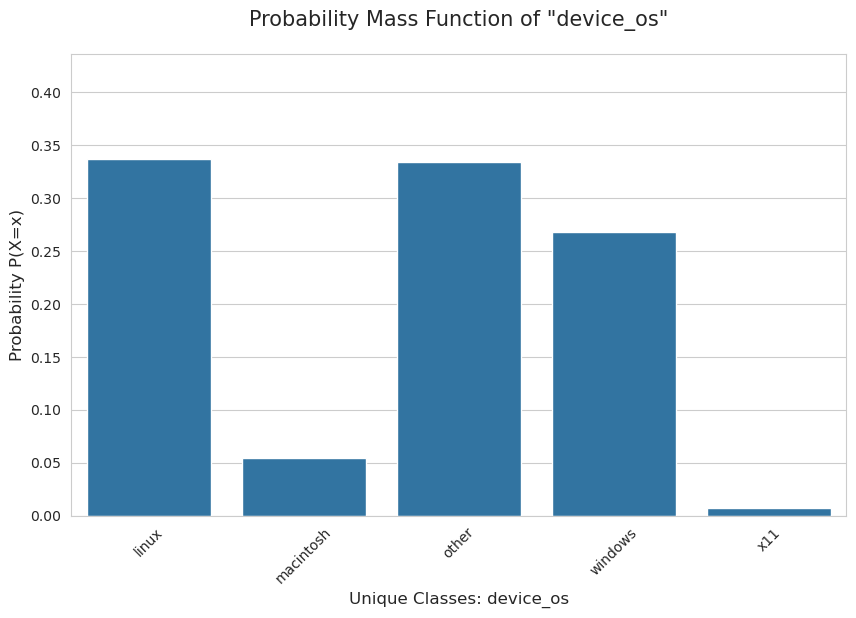

device_os
linux        0.336709
other        0.333875
windows      0.267834
macintosh    0.054103
x11          0.007479
Name: count, dtype: float64

In [131]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = train_dataset["device_os"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["device_os", 'probability']
# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="device_os", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "device_os"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: device_os', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
train_dataset["device_os"].value_counts()/len(train_dataset)


### keep_alive_session

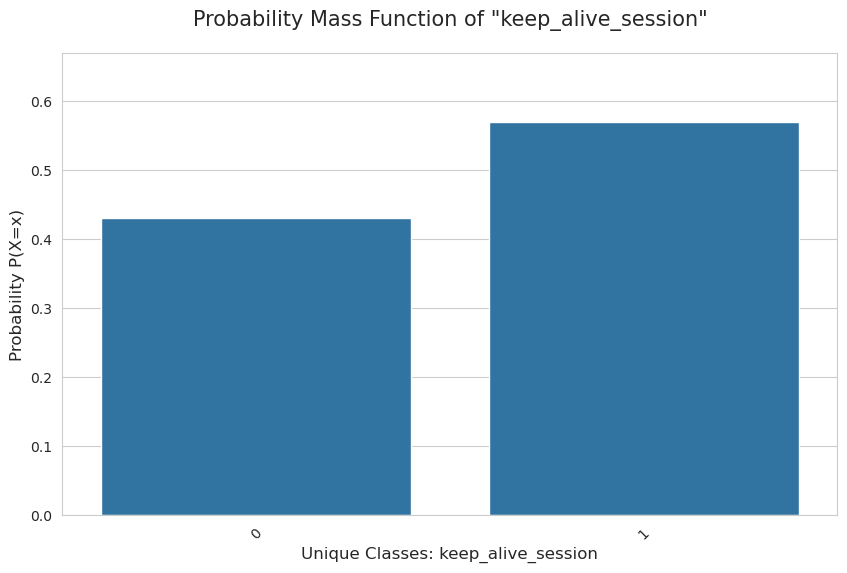

keep_alive_session
1    0.569087
0    0.430913
Name: count, dtype: float64

In [133]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = train_dataset["keep_alive_session"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["keep_alive_session", 'probability']
# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="keep_alive_session", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "keep_alive_session"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: keep_alive_session', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
train_dataset["keep_alive_session"].value_counts()/len(train_dataset)


### device_distinct_emails

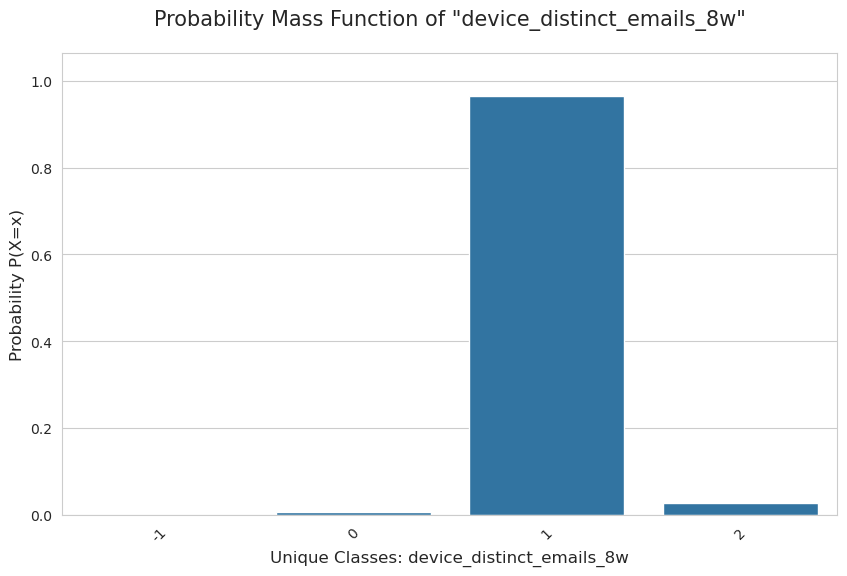

device_distinct_emails_8w
 1    0.964373
 2    0.028407
 0    0.006832
-1    0.000389
Name: count, dtype: float64

In [134]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = train_dataset["device_distinct_emails_8w"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["device_distinct_emails_8w", 'probability']
# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="device_distinct_emails_8w", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "device_distinct_emails_8w"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: device_distinct_emails_8w', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
train_dataset["device_distinct_emails_8w"].value_counts()/len(train_dataset)


### device_fraud_count

In [135]:
train_dataset["device_fraud_count"].unique()

array([0])

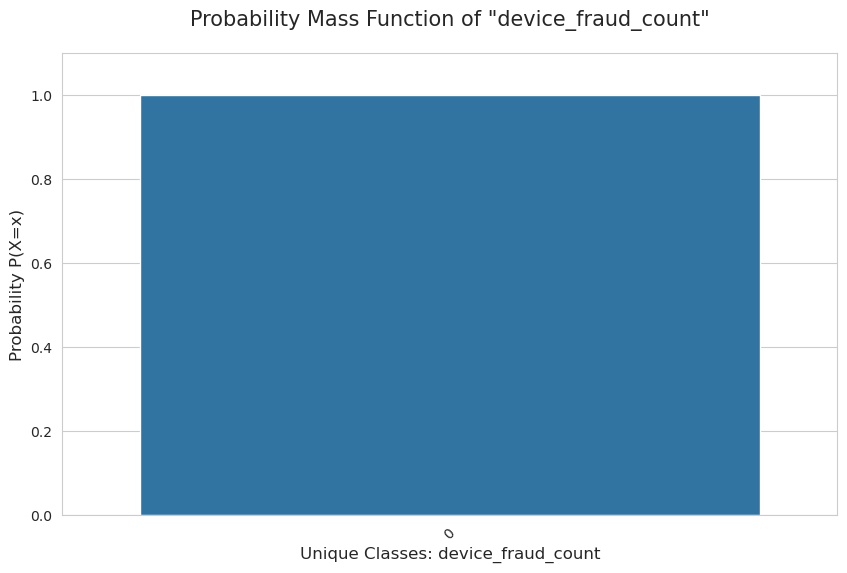

device_fraud_count
0    1.0
Name: count, dtype: float64

In [136]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = train_dataset["device_fraud_count"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["device_fraud_count", 'probability']
# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="device_fraud_count", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "device_fraud_count"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: device_fraud_count', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
train_dataset["device_fraud_count"].value_counts()/len(train_dataset)


### month

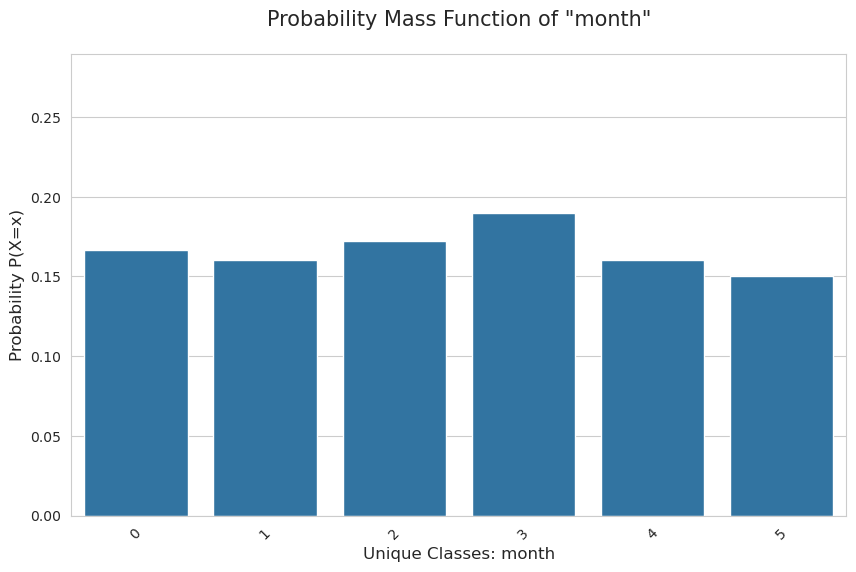

month
3    0.189859
2    0.172303
0    0.166594
4    0.160620
1    0.160531
5    0.150094
Name: count, dtype: float64

In [137]:
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = train_dataset["month"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["month", 'probability']
# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="month", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "month"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: month', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
train_dataset["month"].value_counts()/len(train_dataset)


### fraud_bool

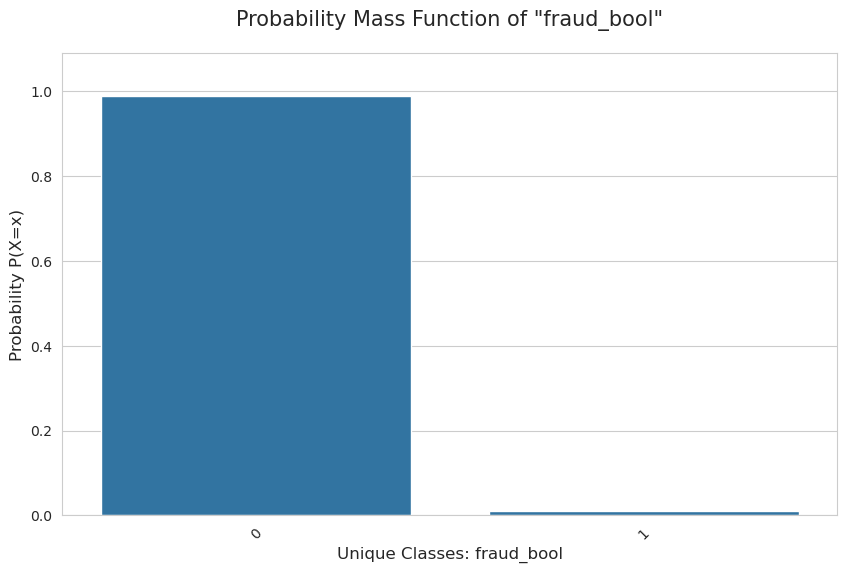

fraud_bool
0    0.989747
1    0.010253
Name: count, dtype: float64

In [138]:
# Make the index column to a column
train_dataset.reset_index(inplace=True)
# 1. Calculate probabilities: P(X = x)
# value_counts(normalize=True) returns relative frequencies
prob_df = train_dataset["fraud_bool"].value_counts(normalize=True).sort_index().reset_index()
prob_df.columns = ["fraud_bool", 'probability']
# 2. Set up the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the bar plot
ax = sns.barplot(
    data=prob_df, 
    x="fraud_bool", 
    y='probability' 
)

# 3. Add labels and styling
plt.title(f'Probability Mass Function of "fraud_bool"', fontsize=15, pad=20)
plt.xlabel(f'Unique Classes: fraud_bool', fontsize=12)
plt.ylabel('Probability P(X=x)', fontsize=12)
plt.ylim(0, prob_df['probability'].max() + 0.1) # Add headroom for labels
plt.xticks(rotation=45)
plt.show()
train_dataset["fraud_bool"].value_counts()/len(train_dataset)


**High imbalanced** in favor of non-fraudulent applications

### Interaction of prev_address_months_count, current_address_months_count, has_other_cards & bank_months_count

1) **prev_address_months_count** missing =>  Either the previous address is not recorded or stays in the current address for a long time or not available. In general, it reflects the **residential_stability**
2) **current_address_months_count**: Similar inference also here.
3) **has_other_cards** It reflects the **relationship depth with bank**
4) **bank_months_count** It reflects the banking history stability.

The interactions of the above four represent a customer profile. For example, if first two are valid recorded and the last two variables reflect that this customer has not been known to the bank as well as there is no info about legacy account-age field.

In [139]:
train_dataset["prev_address_months_count_binary"]=np.where(train_dataset["prev_address_months_count"]<0,"prev_address_missing","prev_address_valid")
train_dataset["current_address_months_count_binary"]=np.where(train_dataset["current_address_months_count"]<0,"current_address_missing","current_address_valid")
train_dataset["has_other_cards_binary"]=np.where(train_dataset["has_other_cards"]==1,"has_other_cards_valid","has_other_cards_invalid")
train_dataset["bank_months_count_binary"]=np.where(train_dataset["bank_months_count"]<0,"bank_months_missing","bank_months_valid")
# 
train_dataset["customer_profile"]=train_dataset["prev_address_months_count_binary"]+"_"+train_dataset["current_address_months_count_binary"]+"_"+train_dataset["has_other_cards_binary"]+"_"+train_dataset["bank_months_count_binary"]
train_dataset["residential_history_stability"]=train_dataset["prev_address_months_count_binary"]+"_"+train_dataset["current_address_months_count_binary"]
train_dataset["banking_relationship_stability"]=train_dataset["bank_months_count_binary"]+"_"+train_dataset["has_other_cards_binary"]

In [140]:
train_dataset["customer_profile"].value_counts(normalize=True)*100

customer_profile
prev_address_missing_current_address_valid_has_other_cards_invalid_bank_months_valid        41.240822
prev_address_valid_current_address_valid_has_other_cards_invalid_bank_months_valid          15.690532
prev_address_missing_current_address_valid_has_other_cards_valid_bank_months_valid          13.955413
prev_address_missing_current_address_valid_has_other_cards_invalid_bank_months_missing      12.949362
prev_address_valid_current_address_valid_has_other_cards_invalid_bank_months_missing         7.360228
prev_address_valid_current_address_valid_has_other_cards_valid_bank_months_valid             3.728731
prev_address_missing_current_address_valid_has_other_cards_valid_bank_months_missing         3.348977
prev_address_valid_current_address_valid_has_other_cards_valid_bank_months_missing           1.345176
prev_address_valid_current_address_missing_has_other_cards_invalid_bank_months_valid         0.243274
prev_address_valid_current_address_missing_has_other_cards_invali

In [141]:
train_dataset["residential_history_stability"].value_counts(normalize=True)*100

residential_history_stability
prev_address_missing_current_address_valid      71.494574
prev_address_valid_current_address_valid        28.124666
prev_address_valid_current_address_missing       0.374596
prev_address_missing_current_address_missing     0.006164
Name: proportion, dtype: float64

In [142]:
train_dataset["banking_relationship_stability"].value_counts(normalize=True)*100

banking_relationship_stability
bank_months_valid_has_other_cards_invalid      57.179030
bank_months_missing_has_other_cards_invalid    20.397138
bank_months_valid_has_other_cards_valid        17.720119
bank_months_missing_has_other_cards_valid       4.703713
Name: proportion, dtype: float64

------------------------------------------------

### Imputation of missing values where needed

1) velocity_6h
2) session_length_in_minutes


In [143]:
# Impute the negative values of velocity_6h using mean imputation
train_dataset['velocity_6h_imputed'] = np.where(train_dataset['velocity_6h'] < 0, train_dataset['velocity_6h'][train_dataset['velocity_6h'] >= 0].mean(), train_dataset['velocity_6h'])
train_dataset['log_velocity_6h_imputed'] = np.log(train_dataset['velocity_6h_imputed'])
# Impute the negative values of session_length_in_minutes using mean imputation
train_dataset["session_length_in_minutes_imputed"]=np.where(train_dataset["session_length_in_minutes"]<0, train_dataset["session_length_in_minutes"][train_dataset["session_length_in_minutes"]>=0].mean(),train_dataset["session_length_in_minutes"])
train_dataset['log_session_length_in_minutes_imputed'] = np.log(train_dataset['session_length_in_minutes_imputed'])


### Drop unnecessary variables

In [144]:
train_dataset.head(3)

,index,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,...,current_address_months_count_binary,has_other_cards_binary,bank_months_count_binary,customer_profile,residential_history_stability,banking_relationship_stability,velocity_6h_imputed,log_velocity_6h_imputed,session_length_in_minutes_imputed,log_session_length_in_minutes_imputed
0,0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,...,current_address_valid,has_other_cards_invalid,bank_months_valid,prev_address_missing_current_address_valid_has...,prev_address_missing_current_address_valid,bank_months_valid_has_other_cards_invalid,13096.035018,9.480065,16.224843,2.786544
1,1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,...,current_address_valid,has_other_cards_invalid,bank_months_valid,prev_address_missing_current_address_valid_has...,prev_address_missing_current_address_valid,bank_months_valid_has_other_cards_invalid,9223.283431,9.129486,3.363854,1.213087
2,2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,...,current_address_valid,has_other_cards_invalid,bank_months_valid,prev_address_valid_current_address_valid_has_o...,prev_address_valid_current_address_valid,bank_months_valid_has_other_cards_invalid,4471.472149,8.405473,22.730559,3.123710


In [ ]:
columns_to_drop_train={"velocity_6h_log","bank_branch_count_8w_log","date_of_birth_distinct_emails_4w_log", 
                      "date_of_birth_distinct_emails_4w_log_original","session_length_in_minutes","session_length_in_minutes_imputed", 
                      "name_email_similarity","velocity_6h","velocity_6h_valid","prev_address_months_count", 
                      "current_address_months_count_binary","current_address_months_count", "device_fraud_count",
                      "month",
                      "phone_home_valid","phone_mobile_valid","has_other_cards","has_other_cards_binary", "index"}
columns_to_drop_test={ "device_fraud_count",  "month"}
train_dataset.drop(columns=columns_to_drop_train, inplace=True)

test_dataset.drop(columns=columns_to_drop_test,inplace=True)

### Export

In [ ]:
train_dataset.to_csv("train_engineered_fraud_dataset.csv", index=False)
test_dataset.to_csv("test_dataset.csv", index=False)


: 